In [1]:
import os
import dotenv
import unicodedata
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as pltgr
from matplotlib.ticker import FuncFormatter
import plotly.express as px
import ipywidgets as ipw
from IPython.display import display

#  vs code muestra los gráficos de plotly de forma nativa
#  Jupyter Notebook del explorador no muestra los gráficos de plotly de forma nativa
# Descomentar lo siguiente si se quiere usar Plotly en Jupyter Notebook del explorador

import plotly.io as pio
pio.renderers.default = 'notebook_connected'

#

In [2]:
def limpiaTexto(texto):
    if not isinstance(texto, str):
        return texto
    # Proteger la ñ y Ñ con un marcador temporal
    texto = texto.replace('ñ', '__enie__').replace('Ñ', '__ENIE__')
    # Quitar tildes
    texto = ''.join(
        c for c in unicodedata.normalize('NFD', texto)
        if unicodedata.category(c) != 'Mn'
    )
    # Restaurar la ñ y Ñ
    return texto.replace('__enie__', 'ñ').replace('__ENIE__', 'Ñ')

In [3]:
def limpiaComunas(texto):
    if not isinstance(texto, str):
        return texto
    coma_pos = texto.find(",")
    if coma_pos != -1:
        tfinal = texto[:coma_pos].lower()
        x = tfinal.find("de chile")
        if x != -1:
            tfinal = tfinal[:x].strip()
        return tfinal
    elif texto.lower().find("santiago") != -1:
        return texto.lower().replace("santiago -", "").strip()
    elif texto.lower().find("- santiago") != -1:
        return texto.lower().replace("- santiago", "").strip()
    return texto.lower()

In [4]:
# Ajustar la cantidad máxima de filas y columnas para mostrar
pd.set_option('display.max_rows', None)  # Mostrar todas las filas
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas

In [5]:
dotenv.load_dotenv()
path_csv = os.getenv("CSV_CHILETRABAJOS")
path_csv2 = os.getenv("CSV_COMPUTRABAJO")
path_csv3 = os.getenv("CSV_INDEED")
geojson = os.getenv("GEOPANDAS_JSON")
cant_datos_final=0
cant_datos_iniciales=0
empleos_no_it= []
with open("trabajos_no_ti.txt", "r",encoding="utf-8") as f:
    for line in f:
        line = line.strip().lower()
        empleos_no_it.append(line)


chile = pd.read_csv("regiones-chile.csv", sep=";",encoding="utf-8")



def limpiaFilas(oferta):
    oferta = oferta.lower()
    # Comprobar si la oferta contiene alguna de las palabras clave
    for empleo in empleos_no_it:
        if empleo in oferta:
            return True
    return False
try:
    df_temp = pd.read_csv(path_csv,sep=";",encoding="utf-8")
    print("Datos de 'chiletrabajos.com' cargados.")
    cant_datos_iniciales += len(df_temp)
    # Limpia caracteres de ofertas
    # Elimna ofertas
    df = df_temp[~df_temp['Oferta'].apply(lambda oferta: limpiaFilas(str(oferta)))]
    cant_datos_final += len(df)
    #display(df.head())
except Exception as e:
        print(f"error :{e}")
        
try:
    df2_temp = pd.read_csv(path_csv2,sep=",",encoding="utf-8")
    print("datos 'computrabajo.com' cargados")
    cant_datos_iniciales += len(df2_temp)
    # Elimina ofertas
    df2 = df2_temp[~df2_temp['Cargo'].apply(lambda oferta: limpiaFilas(str(oferta)))]
    cant_datos_final += len(df2)
    #df2['Cargo'] = df2['Cargo'].apply(limpiaTexto)
    #display(df2.head())
except Exception as e:
        print(f"error :{e}")

try:
    df3 = pd.read_csv(path_csv3,sep=";",encoding="utf-8")
    print("datos 'indeed.com' cargados")
    cant_datos_iniciales += len(df3)
    # Elimina ofertas
    df3 = df3[~df3['oferta'].apply(lambda oferta: limpiaFilas(str(oferta)))]
    cant_datos_final += len(df3)
    #display(df3.head())
except Exception as e:
        print(f"error :{e}")
        
print(f"Cantidad de datos iniciales: {cant_datos_iniciales}")
print(f"Cantidad de datos finales: {cant_datos_final}")


Datos de 'chiletrabajos.com' cargados.
datos 'computrabajo.com' cargados
datos 'indeed.com' cargados
Cantidad de datos iniciales: 8537
Cantidad de datos finales: 4026


In [6]:
# Contamos las ofertas por ubicación en cada dataframe
tabla_ciudades_ct = df['Ubicacion'].value_counts().reset_index()
tabla_ciudades_ct.columns = ['Ciudad/Comuna', 'Cantidad_Ofertas']
tabla_ciudades_ct['Ciudad/Comuna'] = tabla_ciudades_ct['Ciudad/Comuna'].apply(limpiaComunas)

tabla_ciudades_comput = df2['Comuna'].value_counts().reset_index()
tabla_ciudades_comput.columns = ['Ciudad/Comuna', 'Cantidad_Ofertas']
tabla_ciudades_comput['Ciudad/Comuna'] = tabla_ciudades_comput['Ciudad/Comuna'].apply(limpiaComunas)

tabla_ciudades_indeed = df3['ubicacion'].value_counts().reset_index()
tabla_ciudades_indeed.columns = ['Ciudad/Comuna', 'Cantidad_Ofertas']
tabla_ciudades_indeed['Ciudad/Comuna'] = tabla_ciudades_indeed['Ciudad/Comuna'].apply(limpiaComunas)
tabla_ciudades_total = pd.concat([tabla_ciudades_ct, tabla_ciudades_comput, tabla_ciudades_indeed], ignore_index=True)
# Agrupamos por ciudad y sumamos la cantidad de ofertas
tabla_ciudades_total = tabla_ciudades_total.groupby('Ciudad/Comuna', as_index=False).sum()
# Ordenamos por cantidad de ofertas de mayor a menor
tabla_ciudades_total = tabla_ciudades_total.sort_values(by='Cantidad_Ofertas', ascending=False)

# Mostramos la tabla
#print("Total de ofertas por ciudad\n")
#print(print(tabla_ciudades_total.to_string(index=False)))



In [7]:
from matplotlib.ticker import FuncFormatter


def grafico_ofertas_por_ciudad(tabla_ciudades_total=tabla_ciudades_total):
    pltgr.figure(figsize=(10, 6))
    pltgr.bar(tabla_ciudades_total['Ciudad/Comuna'], tabla_ciudades_total['Cantidad_Ofertas'], color='blue')
    pltgr.yscale('log')  # Escala logarítmica en el eje y


    # Personalizar las etiquetas del eje y
    formatter = FuncFormatter(lambda y, _: f'{int(y)}')
    pltgr.gca().yaxis.set_major_formatter(formatter)
    pltgr.xlabel('Ciudad/Comuna')
    pltgr.ylabel('Cantidad de Ofertas')
    pltgr.title('Cantidad de Ofertas por Ciudad/Comuna')
    pltgr.xticks(rotation=90)
    pltgr.tight_layout()
    pltgr.show()
    
    
    # Llamamos a la función para generar el gráfico

In [8]:
# Definimos el orden geográfico de las regiones de norte a sur
orden_regiones = [
    'Arica y Parinacota', 'Tarapacá', 'Antofagasta', 'Atacama', 'Coquimbo', 
    'Valparaíso', 'Metropolitana', 'Libertador B. O Higgins', 'Maule', 'Ñuble', 'Bíobío', 
    'Araucanía', 'Los Ríos', 'Los Lagos', 'Aysén del Gral. C. Ibañez del Campo', 'Magallanes y Antártica Chilena'
]

# Aseguramos que las regiones estén en el orden correcto
df2['Región'] = pd.Categorical(df2['Región'], categories=orden_regiones, ordered=True)

# Contamos la cantidad de ofertas por región
ofertas_por_region = df2['Región'].value_counts().sort_index()

# Creamos el gráfico

def grafico_ofertas_por_region(ofertas_por_region):
    pltgr.figure(figsize=(10, 6))
    ofertas_por_region.plot(kind='bar', color='skyblue')

    # Cambiar la escala del eje y a logaritmica para mejorar la visibilidad
    #pltgr.yscale('log')

    # Personalizamos el gráfico
    pltgr.title('Cantidad de Ofertas Laborales por Región', fontsize=16)
    pltgr.xlabel('Región', fontsize=12)
    pltgr.ylabel('Cantidad de Ofertas', fontsize=12)
    pltgr.xticks(rotation=45, ha='right')
    pltgr.tight_layout()

    # Mostramos el gráfico
    pltgr.show()
    
    


def grafico_ofertas_por_region_interactivo(ofertas_por_region=ofertas_por_region,plot_output=None):
    fig = px.bar(ofertas_por_region, 
                 x=ofertas_por_region.index, 
                 y=ofertas_por_region.values, 
                 labels={'x': 'Región', 'y': 'Cantidad de Ofertas'},
                 title='Cantidad de Ofertas Laborales por Región',
                 color_discrete_sequence=['skyblue'])
    
    fig.update_layout(
        xaxis_title='Región',
        yaxis_title='Cantidad de Ofertas',
        transition=dict(
            duration=500,           # duración en ms
            easing="cubic-in-out"   # estilo de suavizado
        )
    )
    fig.update_traces(
        hovertemplate='<b>Región:</b> %{x}<br><b>Cantidad de ofertas:</b> %{y}<extra></extra>'
    )
    fig.update_yaxes(type='log')  # Escala logarítmica en el eje y
    with plot_output:
        plot_output.clear_output(wait=True)
        fig.show()


C:\Users\Francisco\AppData\Local\Temp\ipykernel_5188\3066959479.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [9]:
import geopandas as gpd

gdf_comunas = gpd.read_file(geojson)
#print(gdf_comunas.head())

# Limpiar datos: eliminar filas con salarios o comunas vacías
df2 = df2.dropna(subset=["Comuna"])


#print(df2["Comuna"])

In [10]:
# Limpiar datos: eliminar filas con salarios o comunas vacías
df2 = df2.dropna(subset=["Salario", "Comuna"])

# Convertir salario a número (por si viene como texto)
df2["Salario"] = pd.to_numeric(df2["Salario"], errors="coerce")
df2 = df2.dropna(subset=["Salario"])  # eliminar si quedó NaN después de convertir

# Agrupar por comuna y calcular salario promedio
salarios_promedio = df2.groupby("Comuna")["Salario"].mean()

# Ordenar de mayor a menor
salarios_promedio = salarios_promedio.sort_values(ascending=False)

# Función para formatear los números como enteros con separador de miles
formatter = FuncFormatter(lambda x, _: f'{int(x):,}'.replace(",", "."))

# Alternar colores
colors = ['seagreen' if i % 2 == 0 else 'mediumseagreen' for i in range(len(salarios_promedio))]

# Graficar
def grafico_salarios_por_comuna(salarios_promedio, colors):
    pltgr.figure(figsize=(12, 6))
    salarios_promedio.plot(kind="bar", color=colors)
    pltgr.title("Salario Promedio por Comuna en Chile (Salarios Informados de computrabajo.cl)")
    pltgr.xlabel("Comuna")
    pltgr.ylabel("Salario Promedio")
    pltgr.xticks(rotation=90, fontsize=8)
    pltgr.gca().yaxis.set_major_formatter(formatter)
    pltgr.tight_layout()
    pltgr.show()

In [11]:
# Limpiar datos
df2 = df2.dropna(subset=["Salario", "Comuna"])
df2["salario"] = pd.to_numeric(df2["Salario"], errors="coerce")
df2 = df2.dropna(subset=["Salario"])

# Agrupar por comuna y calcular salario promedio
salarios_promedio = df2.groupby("Comuna")["Salario"].mean()

# Ordenar las comunas por salario promedio de mayor a menorvvvvvvvvvvvvvvvvvvvvvv
comunas_ordenadas = salarios_promedio.sort_values(ascending=False).index

# Función para formatear los números como enteros con separador de miles
formatter = FuncFormatter(lambda x, _: f'{int(x):,}'.replace(",", "."))

# Graficar
pltgr.figure(figsize=(12, 8))

# Crear scatter plot para todos los salarios, agrupados por comuna


# Dibujar la línea continua de la media por comuna
# Usamos plt.plot para conectar las medias de cada comuna con una línea continua

def plot_media_por_comuna(salarios_promedio, comunas_ordenadas):
    for comuna in comunas_ordenadas:
        salarios_comuna = df2[df2["Comuna"] == comuna]["Salario"]
        pltgr.scatter([comuna] * len(salarios_comuna), salarios_comuna, alpha=0.6, label=comuna, color='midnightblue')
    pltgr.plot(comunas_ordenadas, salarios_promedio[comunas_ordenadas], color='crimson', linestyle='-', linewidth=2, label="Media por Comuna")

    # Personalización del gráfico
    pltgr.title("Distribución de Salarios por Comuna en Chile y su Media (Salarios Informados por computrabajo.cl)", fontsize=14)
    pltgr.xlabel("Comuna", fontsize=12)
    pltgr.ylabel("Salario (CLP)", fontsize=12)
    pltgr.xticks(rotation=90, fontsize=8)
    pltgr.yticks(fontsize=8)
    pltgr.gca().yaxis.set_major_formatter(formatter)

    # Ajuste de tamaño para evitar superposición de etiquetas
    pltgr.tight_layout()
    pltgr.legend(title="Distribución de Salarios por Comuna en Chile y su Media", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    pltgr.show()

<Figure size 1200x800 with 0 Axes>

In [12]:
# Limpiar datos: eliminar filas con salarios o regiones vacías
df2 = df2.dropna(subset=["Salario", "Región"])

# Convertir salario a número (por si viene como texto)
df2["Salario"] = pd.to_numeric(df2["Salario"], errors="coerce")
df2 = df2.dropna(subset=["Salario"])  # eliminar si quedó NaN después de convertir

# Agrupar por región y calcular salario promedio
salarios_promedio = df2.groupby("Región")["Salario"].mean()

# Ordenar de mayor a menor
salarios_promedio = salarios_promedio.sort_values(ascending=False)

# Función para formatear los números como enteros con separador de miles
formatter = FuncFormatter(lambda x, _: f'{int(x):,}'.replace(",", "."))

# Graficar
def grafico_salarios_por_region(salarios_promedio):
    # Alternar colores
    colors = ['seagreen' if i % 2 == 0 else 'mediumseagreen' for i in range(len(salarios_promedio))]

    # Graficar
    pltgr.figure(figsize=(12, 8))
    salarios_promedio.plot(kind="bar", color='mediumseagreen')
    pltgr.title("Salario Promedio por Región en Chile (Salarios Informados de computrabajo.cl)")
    pltgr.xlabel("Región")
    pltgr.ylabel("Salario Promedio")
    pltgr.xticks(rotation=45, ha='right')
    pltgr.gca().yaxis.set_major_formatter(formatter)
    pltgr.tight_layout()
    pltgr.savefig('../graficos/salario_promedio_por_region.png', dpi=300, bbox_inches='tight')
    pltgr.show()
    
    


C:\Users\Francisco\AppData\Local\Temp\ipykernel_5188\4158850392.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [13]:
# Filtrar ofertas con salarios en cada dataframe
ofertas_con_salario_ct = df[df['Salario'].notnull()]
ofertas_con_salario_comput = df2[df2['Salario'].notnull()]
ofertas_con_salario_indeed = df3[df3['salario'].notnull()]

import re
def es_salario_valido(salario):
    if isinstance(salario, str):
        return bool(re.match(r'^\d+(\.\d+)?$', salario))
    return False


# Eliminar puntos en los valores de la columna 'Salario' si los detecta
ofertas_con_salario_ct['Salario'] = ofertas_con_salario_ct['Salario'].str.replace('.', '', regex=False)


## Chiletrabajos df
ofertas_con_salario_ct = ofertas_con_salario_ct[ofertas_con_salario_ct['Salario'].apply(es_salario_valido)]


## indeed csv 
ofertas_con_salario_indeed['salario'] = ofertas_con_salario_indeed['salario'].str.replace("por mes", "", regex=False).str.replace("$", "", regex=False).str.replace(".","").str.strip()
# Eliminar salarios que tienen solo números iguales

# Separar en dos filas si hay un "-"
ofertas_con_salario_indeed = ofertas_con_salario_indeed.assign(salario=ofertas_con_salario_indeed['salario'].str.split('-')).explode('salario')
ofertas_con_salario_indeed['salario'] = ofertas_con_salario_indeed['salario'].str.strip()

# Filtrar las filas que contienen "por hora" en la columna salario
ofertas_con_salario_indeed = ofertas_con_salario_indeed[~ofertas_con_salario_indeed['salario'].str.contains("por hora", na=False)]
ofertas_con_salario_indeed['salario'] = ofertas_con_salario_indeed['salario'].str.replace(".","")

## Computrabajo df2
# Eliminar el .0 de los valores de salario en df2
ofertas_con_salario_comput['Salario'] = ofertas_con_salario_comput['Salario'].astype(str).str.replace('.0', '', regex=False).str.strip()

# Limpiar las comunas en cada dataframe de ofertas con salario
ofertas_con_salario_ct['Ubicacion'] = ofertas_con_salario_ct['Ubicacion'].apply(limpiaComunas)
ofertas_con_salario_comput['Comuna'] = ofertas_con_salario_comput['Comuna'].apply(limpiaComunas)
ofertas_con_salario_indeed['ubicacion'] = ofertas_con_salario_indeed['ubicacion'].apply(limpiaComunas)

# Convertir las columnas de salario a tipo numérico, manejando errores
ofertas_con_salario_ct['Salario'] = pd.to_numeric(ofertas_con_salario_ct['Salario'], errors='coerce')
ofertas_con_salario_comput['Salario'] = pd.to_numeric(ofertas_con_salario_comput['Salario'], errors='coerce')
ofertas_con_salario_indeed['salario'] = pd.to_numeric(ofertas_con_salario_indeed['salario'], errors='coerce')

# Eliminar salarios que contengan números iguales o
ofertas_con_salario_ct = ofertas_con_salario_ct[~ofertas_con_salario_ct['Salario'].astype(str).str.match(r'^(\d)\1+$')]
ofertas_con_salario_ct = ofertas_con_salario_ct[ofertas_con_salario_ct['Salario'] >= 100000]

ofertas_con_salario_comput = ofertas_con_salario_comput[~ofertas_con_salario_comput['Salario'].astype(str).str.match(r'^(\d)\1+$')]
ofertas_con_salario_comput = ofertas_con_salario_comput[ofertas_con_salario_comput['Salario'] >= 1000000]

ofertas_con_salario_indeed = ofertas_con_salario_indeed[~ofertas_con_salario_indeed['salario'].astype(str).str.match(r'^(\d)\1+$')]
ofertas_con_salario_indeed = ofertas_con_salario_indeed[ofertas_con_salario_indeed['salario'] >= 1000000]

# Calcular el promedio de salarios por ciudad/comuna
promedio_salarios_ct = ofertas_con_salario_ct.groupby('Ubicacion')['Salario'].mean().reset_index()
promedio_salarios_ct.columns = ['Ciudad/Comuna', 'Promedio_Salario']

promedio_salarios_comput = ofertas_con_salario_comput.groupby('Comuna')['Salario'].mean().reset_index()
promedio_salarios_comput.columns = ['Ciudad/Comuna', 'Promedio_Salario']

promedio_salarios_indeed = ofertas_con_salario_indeed.groupby('ubicacion')['salario'].mean().reset_index()
promedio_salarios_indeed.columns = ['Ciudad/Comuna', 'Promedio_Salario']

# Concatenar los promedios de salarios de los tres dataframes
promedio_salarios_total = pd.concat([promedio_salarios_ct, promedio_salarios_comput, promedio_salarios_indeed], ignore_index=True)

# Agrupar por ciudad/comuna y calcular el promedio final
promedio_salarios_total = promedio_salarios_total.groupby('Ciudad/Comuna', as_index=False).mean()

# Mostrar el resultado
#print("Promedio de salarios por ciudad/comuna\n")
#print(promedio_salarios_total.to_string(index=False))
# Filtrar los valores de salarios de Valparaíso



C:\Users\Francisco\AppData\Local\Temp\ipykernel_5188\32355610.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Francisco\AppData\Local\Temp\ipykernel_5188\32355610.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
# Gráfico de salarios promedio por ciudad
def grafico_salarios_promedio_por_ciudad(salarios_promedio):
    # Alternar colores
    colors = ['seagreen' if i % 2 == 0 else 'mediumseagreen' for i in range(len(salarios_promedio))]

    # Graficar
    pltgr.figure(figsize=(12, 8))
    salarios_promedio.plot(kind="bar", color=colors)
    pltgr.title("Salario Promedio por Ciudad en Chile (Salarios Informados de computrabajo.cl)")
    pltgr.xlabel("Ciudad")
    pltgr.ylabel("Salario Promedio")
    pltgr.xticks(rotation=90, fontsize=8)
    pltgr.gca().yaxis.set_major_formatter(formatter)
    pltgr.tight_layout()
    pltgr.savefig('../graficos/salario_promedio_por_ciudad.png', dpi=300, bbox_inches='tight')
    pltgr.show()
    
# Llamamos a las funciones para generar los gráficos
#grafico_ofertas_por_ciudad(tabla_ciudades_total)

In [15]:
def clasificar_puesto(oferta):
    oferta = str(oferta).lower().replace('\"','').strip()
    categorias = {
            "Fullstack": ['angular net core','web master','fullstack', 'full stack', 'full-stack'],
            "Frontend": ['frontend', 'front end', 'front-end'],
            "Backend": ['hosting','oracle','backend', 'back end', 'back-end', 'sql'],
            "Data Scientist": ['data','data scientist', 'big data', 'bigdata', 'datos', 'data engineer', 'ingeniero de datos', 'analytics engineer'],
            "Lider de proyecto": ['jefe de aplicaciones','pmo','ingeniero de proyectos','jefe/a de proyectos','jefe de ti','business owner','product manager','lider de proyectos','ágil coach','lider ti','ingeniero proyecto','management lead','product owner','jefa/e de proyectos','agile coach','ingeniero de proyectos/procesos','jefe de desarrollo','jefe de informática','líder', 'scrum master', 'jefe de proyecto','jefe proyecto', 'project manager', 'tech lead','technical lead'],
            "Cloud": ['cloud', 'aws', 'azure', 'gcp'],
            "DevOps": ['devops'],
            "Ciberseguridad": ['forensic','auditor','fraud manager','security','ciberseguridad', 'seguridad', 'ethical hacking', 'ethical hacker', 'penetration tester'],
            "UX/UI": ['product designer','ux', 'ui', 'ux/ui', 'diseñador ux', 'diseñadora ux'],
            "Mobile": ['mobile', 'movil', 'android', 'ios', 'react native'],
            "QA": ['qa', 'tester', 'testeo','quality assurance', 'aseguramiento de calidad', 'control de calidad','quality'],
            "Analista": ['analista','analyst'],
            "Developer": ['ingeniero de aplicaciones','development','.net','desasrollador','programación','ingeniero en programación','desarrollo','progrmador','ingeniero desarrollo de software','developer', 'programador', 'desarrollador', 'ingeniero de software', 'software engineer', 'programador java', 'programador php'],
            "Soporte Técnico": ['it help','support','customer assistance','soporte', 'mantenimiento', 'mesa de ayuda', 'helpdesk'],
            "Técnico": ['técnico','tecnico', 'técnico informático', 'técnico en telecomunicaciones', 'técnico en computación'],
            "Práctica Profesional": ['práctica','practica', 'alumno en práctica'],
            "Arquitecto de Software": ['arquitecto de software', 'arquitecta de software'],
            "Consultor": ['consultant','account manager','consultor', 'consultora', 'consulting'],
            "Administrador": ['servidores','manager','encargado ti','encargado de sistema','jefe (a) plataforma','administrador', 'gestor'],
            "Redes": ['networking','networking engineer','redes', 'comunicaciones', 'telecomunicaciones'],
            "Business Intelligence": ['web analytics','business analyst','business analytics','business intelligence', 'bi'],
            "Especialista en Sistemas": ['dba','sap','platform engineer','sistemas', 'infraestructura'],
            "Ingeniero de IA": ['machine learning', 'inteligencia artificial', 'ia', 'ingeniero de ia']
        }
    

    for categoria, keywords in categorias.items():
        if any(kw in oferta for kw in keywords):
            return categoria
    
    with open("otros.txt", "a", encoding="utf-8") as f:
        f.write(f"{oferta}\n")

    return "Otros"

# Clasificar los puestos en cada DataFrame
df['Puesto'] = df['Oferta'].apply(clasificar_puesto)
df2['Puesto'] = df2['Cargo'].apply(clasificar_puesto)
df3['Puesto'] = df3['oferta'].apply(clasificar_puesto)

# Limpiar las comunas en cada DataFrame
df['Ubicacion'] = df['Ubicacion'].apply(limpiaComunas)
df2['Comuna'] = df2['Comuna'].apply(limpiaComunas)
df3['ubicacion'] = df3['ubicacion'].apply(limpiaComunas)

# Crear tablas de cantidad de ofertas por tipo de puesto y comuna
tabla_puestos_comunas_ct = df.groupby(['Ubicacion', 'Puesto']).size().reset_index(name='Cantidad_Ofertas')
tabla_puestos_comunas_comput = df2.groupby(['Comuna', 'Puesto']).size().reset_index(name='Cantidad_Ofertas')
tabla_puestos_comunas_indeed = df3.groupby(['ubicacion', 'Puesto']).size().reset_index(name='Cantidad_Ofertas')

# Renombrar las columnas para unificar
tabla_puestos_comunas_ct.columns = ['Comuna', 'Puesto', 'Cantidad_Ofertas']
tabla_puestos_comunas_comput.columns = ['Comuna', 'Puesto', 'Cantidad_Ofertas']
tabla_puestos_comunas_indeed.columns = ['Comuna', 'Puesto', 'Cantidad_Ofertas']

# Concatenar las tablas
tabla_puestos_comunas_total = pd.concat(
    [tabla_puestos_comunas_ct, tabla_puestos_comunas_comput, tabla_puestos_comunas_indeed],
    ignore_index=True
)

# Agrupar por comuna y tipo de puesto, sumando la cantidad de ofertas
tabla_puestos_comunas_total = tabla_puestos_comunas_total.groupby(['Comuna', 'Puesto'], as_index=False).sum()

# Mostrar la tabla resultante
#print("Cantidad de ofertas por tipo de puesto y comuna\n")
#print(tabla_puestos_comunas_total.to_string(index=False))


C:\Users\Francisco\AppData\Local\Temp\ipykernel_5188\1367351077.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Francisco\AppData\Local\Temp\ipykernel_5188\1367351077.py:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
# data frames de ofertas con salario
# ofertas_con_salario_ct , ofertas_con_salario_comput, ofertas_con_salario_indeed
# Crear tablas de promedio de salarios por tipo de puesto
# Aplicar la función clasificar_puesto a las tablas de ofertas con salario}

ofertas_con_salario_ct['Puesto'] = ofertas_con_salario_ct['Oferta'].apply(clasificar_puesto)
ofertas_con_salario_comput['Puesto'] = ofertas_con_salario_comput['Cargo'].apply(clasificar_puesto)
ofertas_con_salario_indeed['Puesto'] = ofertas_con_salario_indeed['oferta'].apply(clasificar_puesto)
promedio_salarios_ct_puesto = ofertas_con_salario_ct.groupby('Puesto')['Salario'].mean().reset_index()
promedio_salarios_ct_puesto.columns = ['Puesto', 'Promedio_Salario']

promedio_salarios_comput_puesto = ofertas_con_salario_comput.groupby('Puesto')['Salario'].mean().reset_index()
promedio_salarios_comput_puesto.columns = ['Puesto', 'Promedio_Salario']

promedio_salarios_indeed_puesto = ofertas_con_salario_indeed.groupby('Puesto')['salario'].mean().reset_index()
promedio_salarios_indeed_puesto.columns = ['Puesto', 'Promedio_Salario']

# Concatenar las tablas de promedio de salarios
promedio_salarios_puesto_total = pd.concat(
    [promedio_salarios_ct_puesto, promedio_salarios_comput_puesto, promedio_salarios_indeed_puesto],
    ignore_index=True
)

# Agrupar por tipo de puesto y calcular el promedio final
promedio_salarios_puesto_total = promedio_salarios_puesto_total.groupby('Puesto', as_index=False).mean()

# Mostrar la tabla resultante
#print("Promedio de salarios por tipo de puesto\n")
#print(promedio_salarios_puesto_total.to_string(index=False))

In [17]:
def grafico_salarios_promedio_por_puesto(promedio_salarios_puesto_total):
    pltgr.figure(figsize=(12, 8))
    pltgr.bar(
        promedio_salarios_puesto_total['Puesto'],
        promedio_salarios_puesto_total['Promedio_Salario'],
        color='purple', alpha=0.8, edgecolor='black'
    )
    pltgr.title('Salarios Promedio por Tipo de Puesto', fontsize=16)
    pltgr.xlabel('Puesto', fontsize=12)
    pltgr.ylabel('Promedio de Salarios (CLP)', fontsize=12)
    pltgr.xticks(rotation=90, fontsize=10)
    pltgr.ticklabel_format(style='plain', axis='y')
    pltgr.tight_layout()
    pltgr.show()


In [18]:
# Concatenamos ambas tablas
tabla_total = pd.concat([tabla_puestos_comunas_ct, tabla_puestos_comunas_comput, tabla_puestos_comunas_indeed])

# Agrupamos por 'Puesto' y sumamos las ofertas
tabla_total = tabla_total.groupby('Puesto', as_index=False).sum()

# Ordenamos de mayor a menor cantidad de ofertas
tabla_total = tabla_total.sort_values(by='Cantidad_Ofertas', ascending=False)


# Mostramos la tabla final
#print("Total de ofertas por puesto (sumando Chiletrabajos y Computrabajo)\n")
tabla_total = tabla_total.sort_values(by='Puesto', ascending=True)
#print(tabla_total.to_string(index=False))



# Crear un gráfico de barras para cada comuna mostrando los tipos de puestos
# Crear gráficos de torta para cada comuna mostrando los tipos de puestos
comunas_unicas = tabla_puestos_comunas_total['Comuna'].unique()

def graficos_puestos_por_comuna(comuna,tabla=tabla_total):
    # Filtrar la tabla para la comuna seleccionada
    tabla_comuna = tabla_puestos_comunas_total[tabla_puestos_comunas_total['Comuna'] == comuna.lower()]

    if tabla_comuna.empty:
        print(f"No hay datos para la comuna '{comuna}'.")
        return

    # Ordenar por cantidad de ofertas
    tabla_comuna = tabla_comuna.sort_values(by='Cantidad_Ofertas', ascending=False)

    # Pie chart
    pltgr.figure(figsize=(8, 8))
    pltgr.pie(
        tabla_comuna['Cantidad_Ofertas'],
        labels=tabla_comuna['Puesto'],
        autopct='%1.1f%%',
        startangle=140,
        pctdistance=0.85,
        labeldistance=1.1
    )
    pltgr.title(f'Distribución de Ofertas por Puesto en {comuna.capitalize()}')
    pltgr.tight_layout()
    pltgr.show()

def grafico_iteract_ofertas_por_ciudad(comuna, df=tabla_total, plot_output=None):  
    # Filtrar los datos para la comuna seleccionada
    datos = tabla_puestos_comunas_total[tabla_puestos_comunas_total['Comuna'].str.lower() == comuna.lower()]
    if datos.empty:
        print(f"No hay datos para la comuna '{comuna}'.")
        return
    fig = px.pie(
        datos,
        names="Puesto",
        values="Cantidad_Ofertas",
        title=f"Distribución de Puestos en {comuna.capitalize()}",
        hole=0.4,
        custom_data=["Puesto", "Cantidad_Ofertas"]
    )
    fig.update_traces(
        textinfo='label',
        hovertemplate='<b>Puesto:</b> %{label}<br><b>Cantidad de ofertas:</b> %{value}<extra></extra>'
    )
    fig.update_layout(
        transition=dict(
            duration=500,  # milisegundos
            easing="cubic-in-out"
        )
    )

    if plot_output is not None:
        with plot_output:
            plot_output.clear_output(wait=True)
            fig.show()
    else:
        fig.show()

#graficos_puestos_por_comuna("antofagasta")


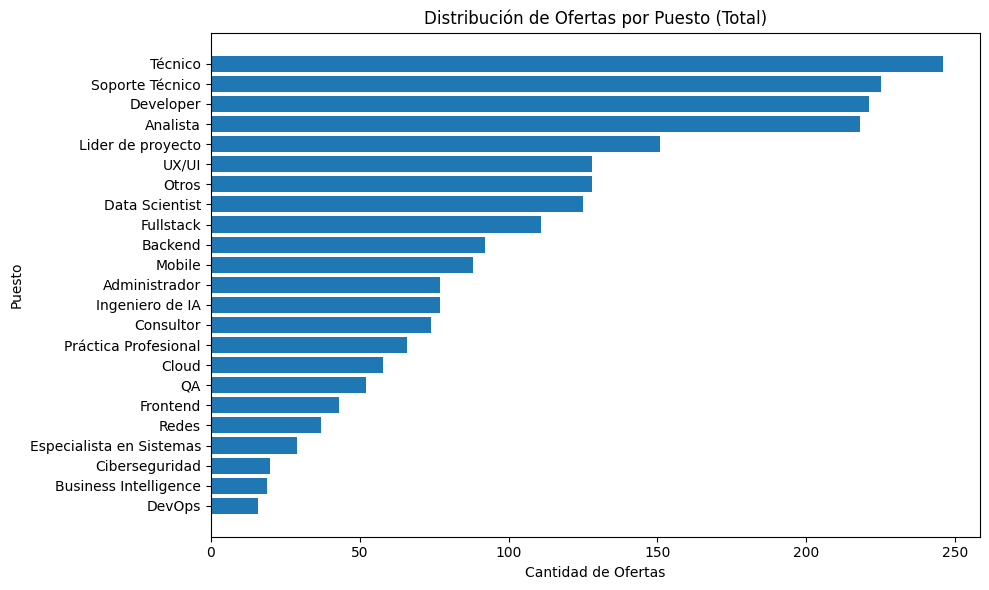

In [19]:
# Pie chart de puestos
tabla_total_sorted = tabla_total.sort_values(by='Cantidad_Ofertas', ascending=True)

pltgr.figure(figsize=(10, 6))
pltgr.barh(tabla_total_sorted['Puesto'], tabla_total_sorted['Cantidad_Ofertas'])
pltgr.xlabel('Cantidad de Ofertas')
pltgr.ylabel('Puesto')
pltgr.title('Distribución de Ofertas por Puesto (Total)')
pltgr.tight_layout()
pltgr.show()




In [20]:

def grafico_distrib_ofertas_puestos(tabla):
    labels = tabla['Puesto']
    sizes = tabla['Cantidad_Ofertas']

    # Explode la categoría más grande (opcional)
    explode = [0.1 if s == max(sizes) else 0 for s in sizes]

    pltgr.figure(figsize=(8, 8))
    pltgr.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        explode=explode,
        pctdistance=0.85,
        labeldistance=1.1
    )
    pltgr.title('Distribución de Ofertas por Puesto (Total)')
    pltgr.tight_layout()

    pltgr.show()
    
## 
#grafico_distrib_ofertas_puestos(tabla_total)

Total de tecnologías encontradas: 675


C:\Users\Francisco\AppData\Local\Temp\ipykernel_5188\2538270316.py:57: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



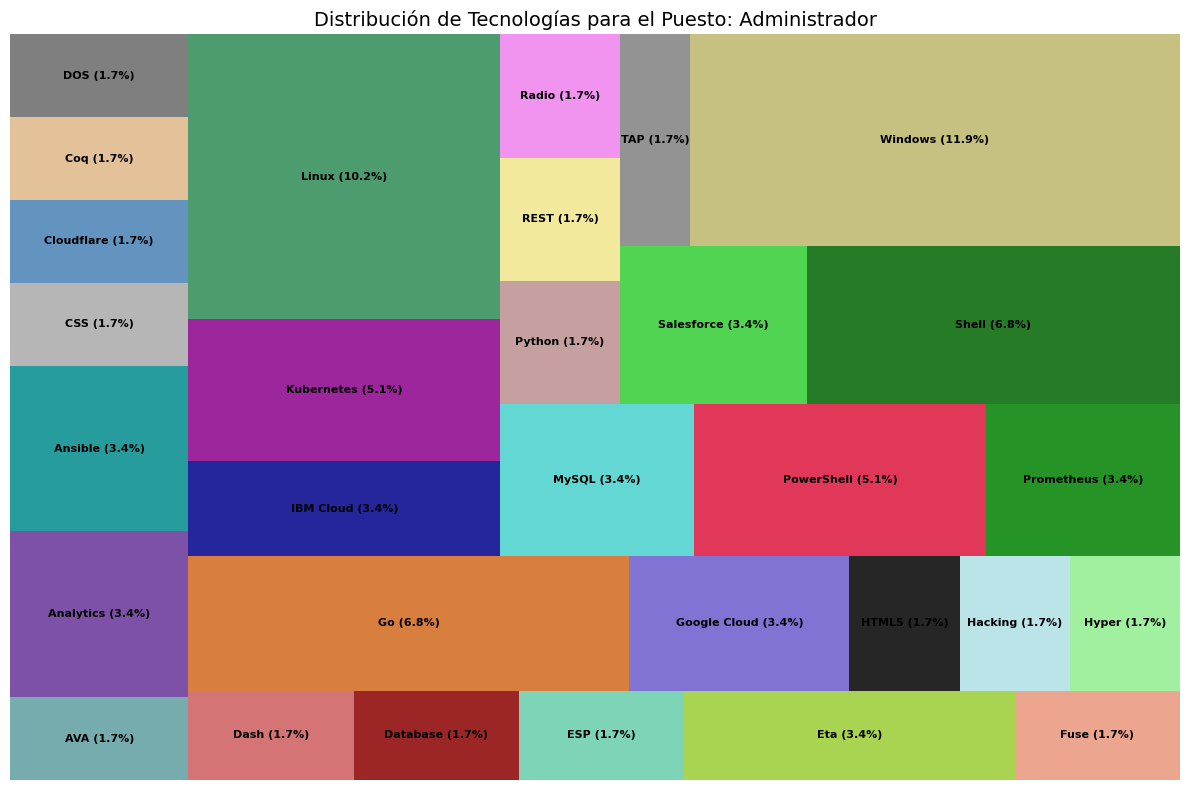

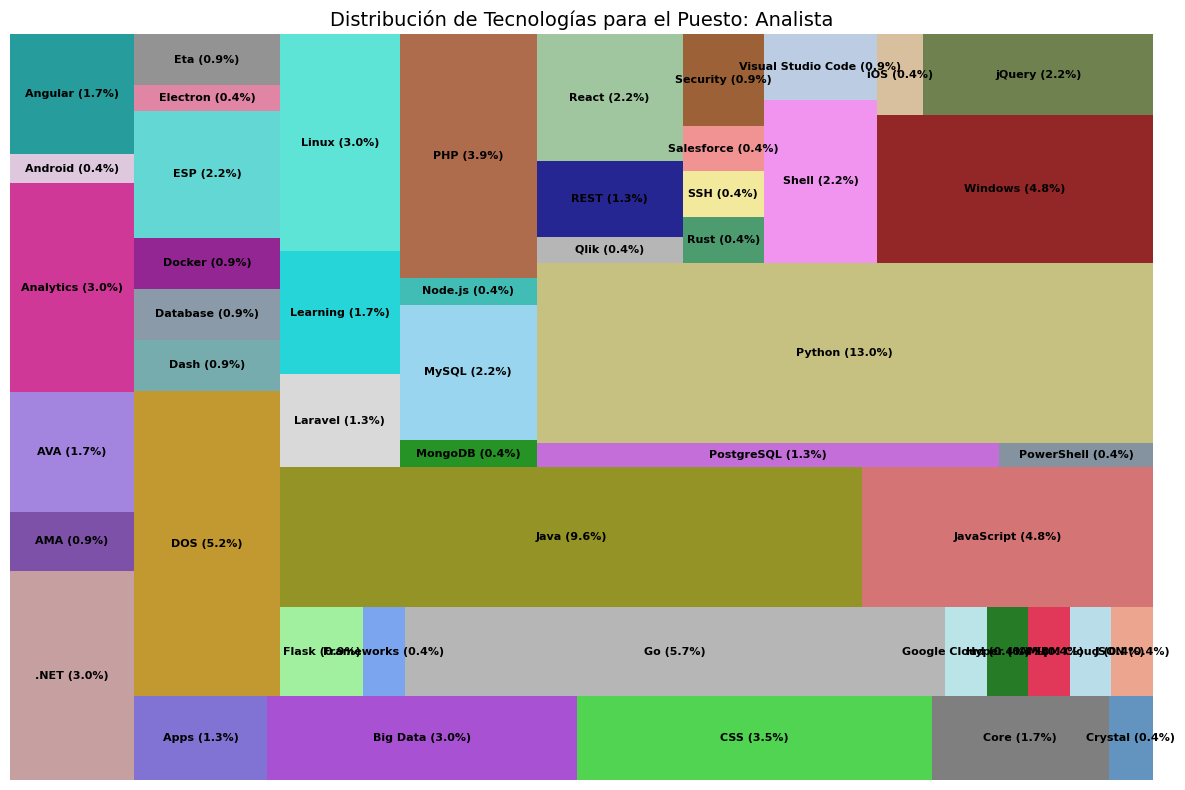

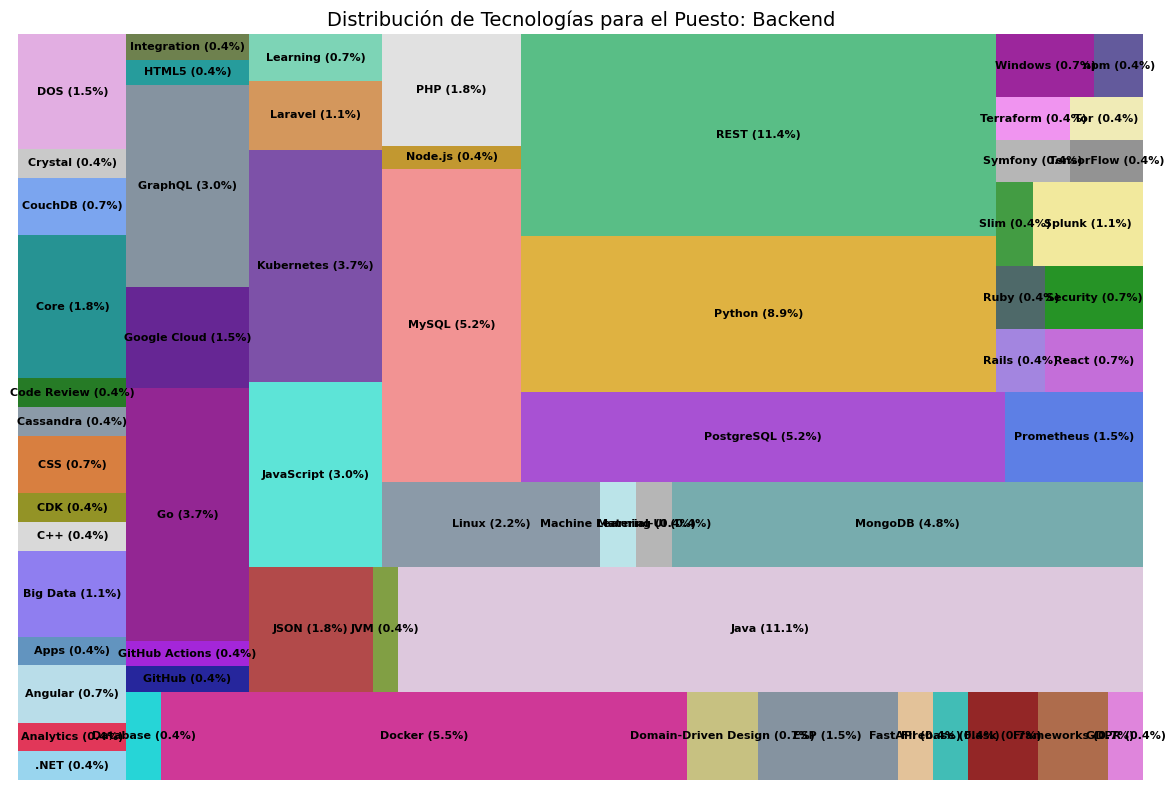

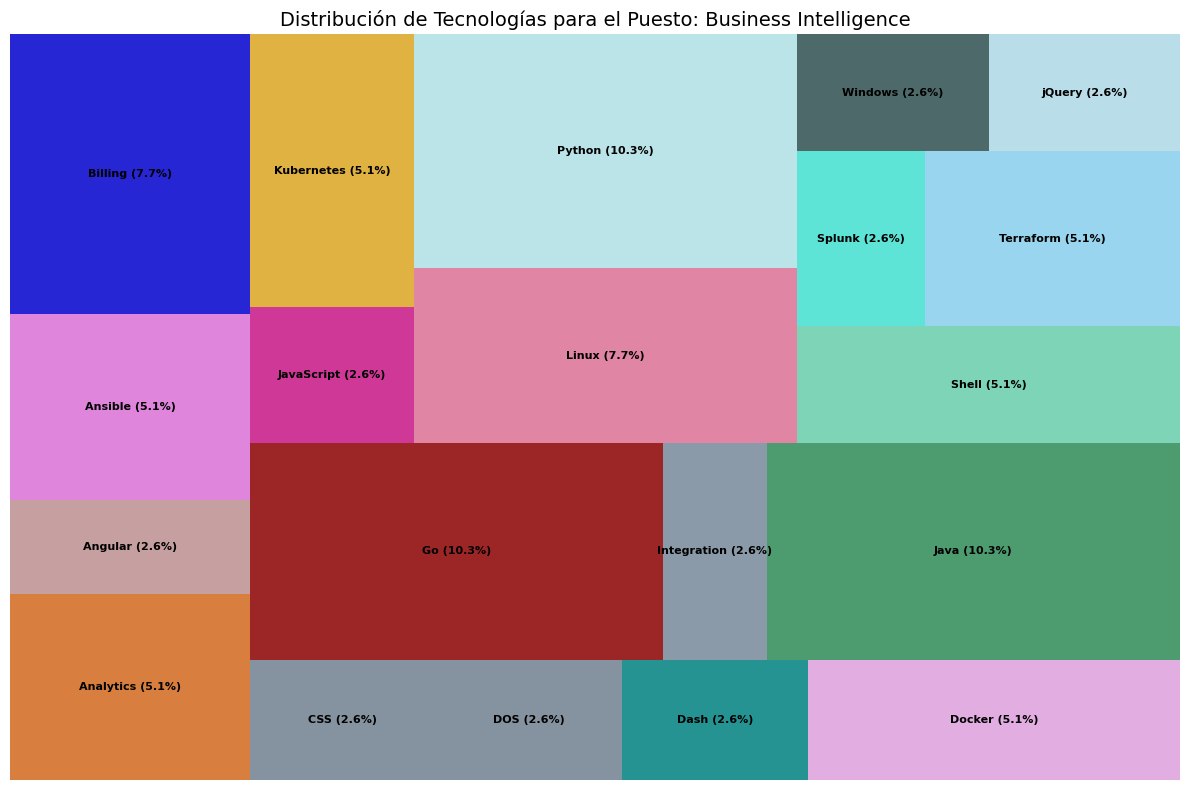

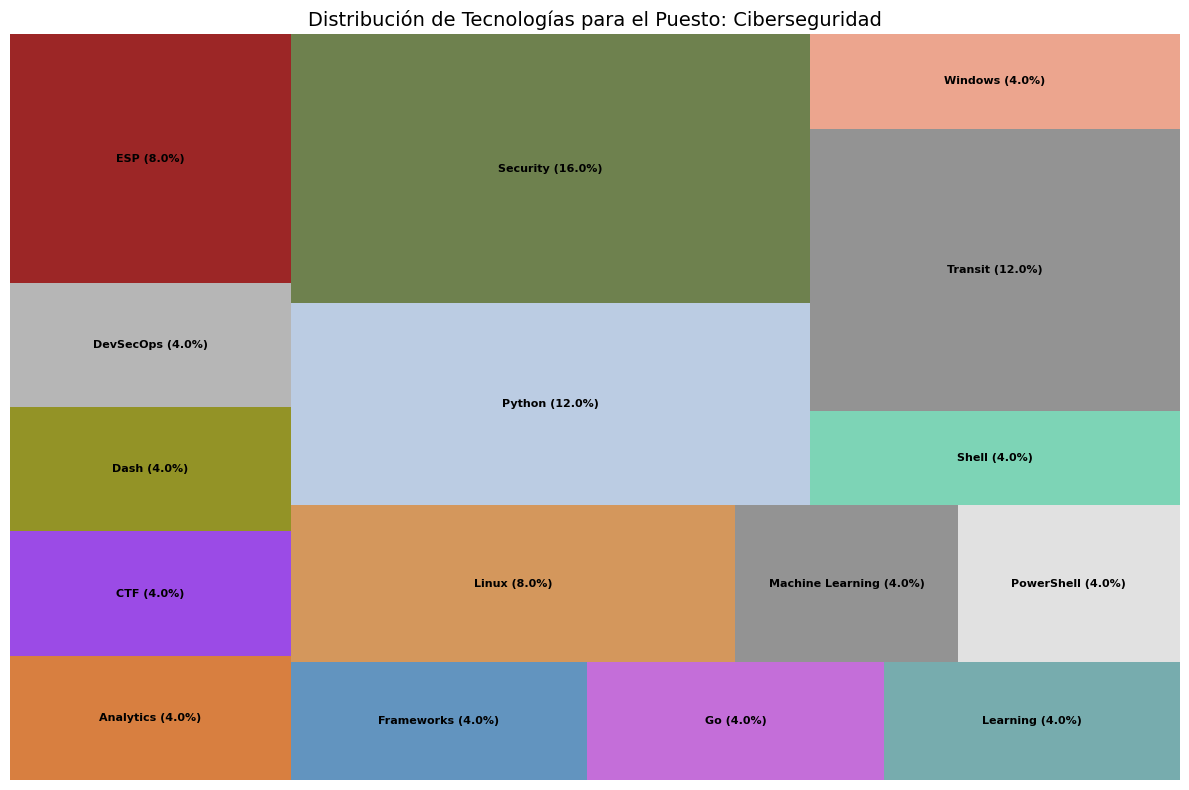

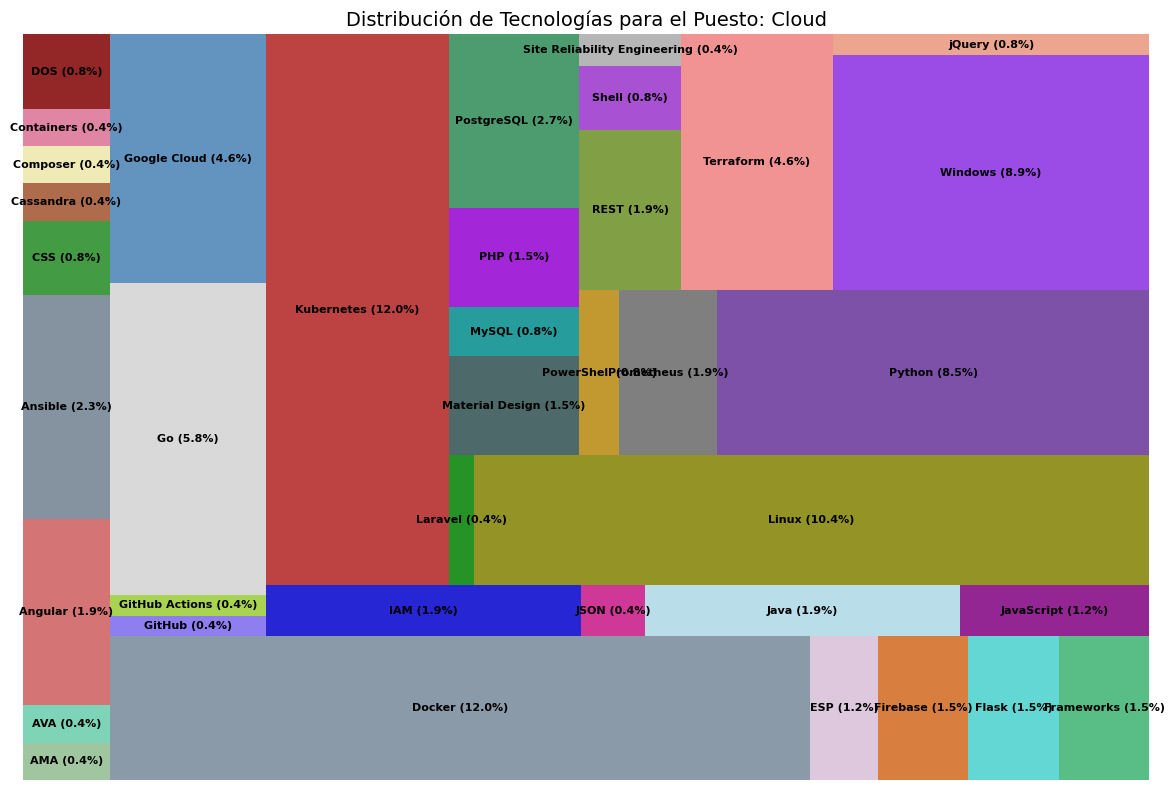

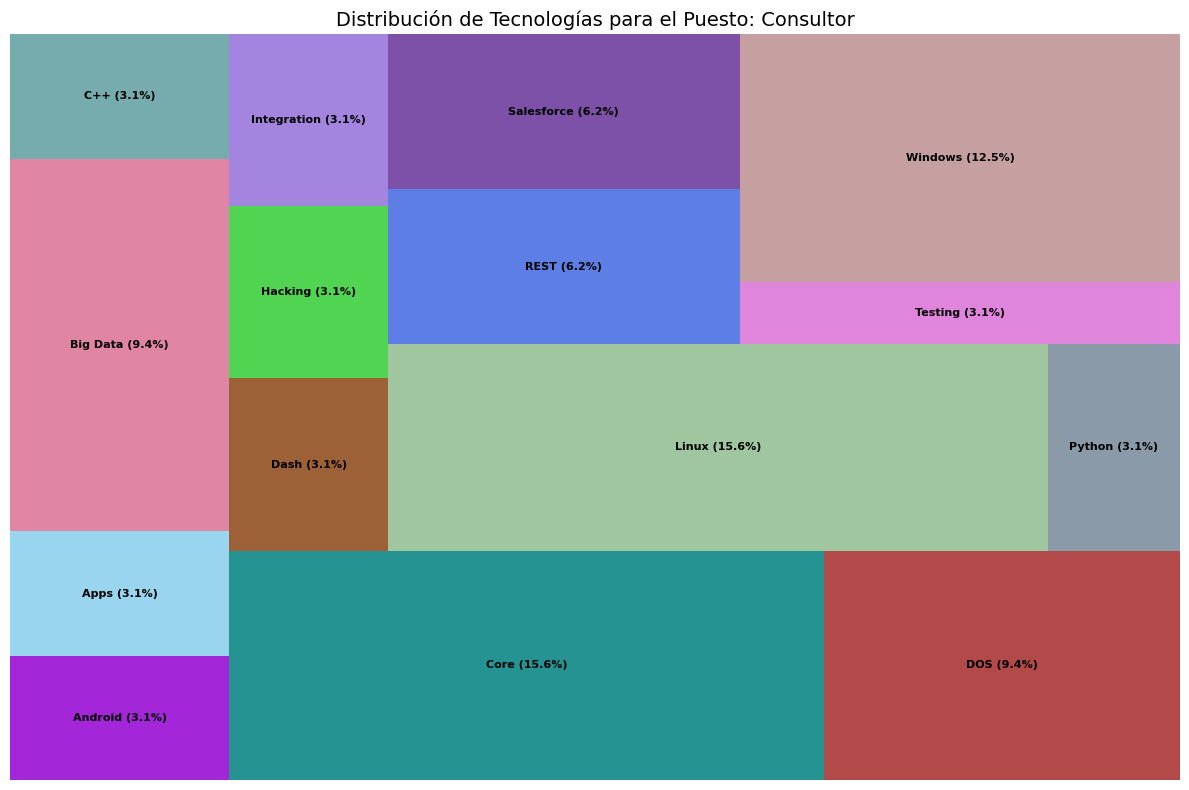

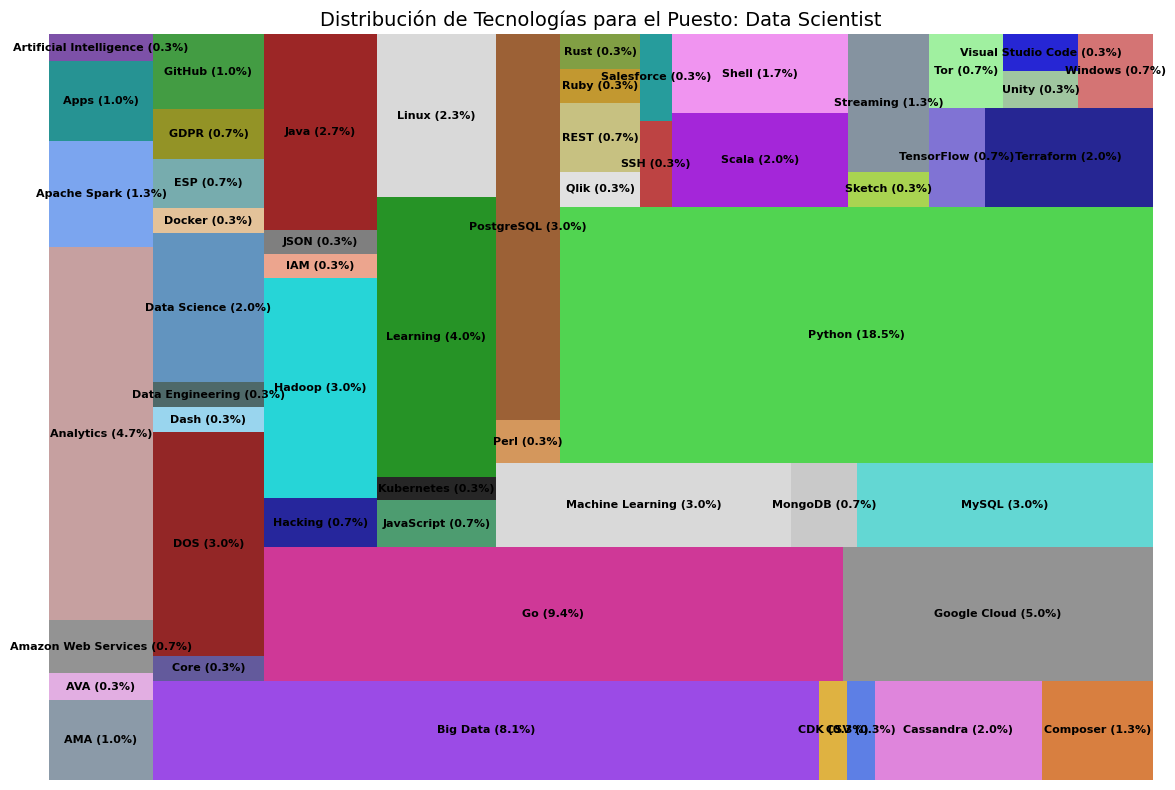

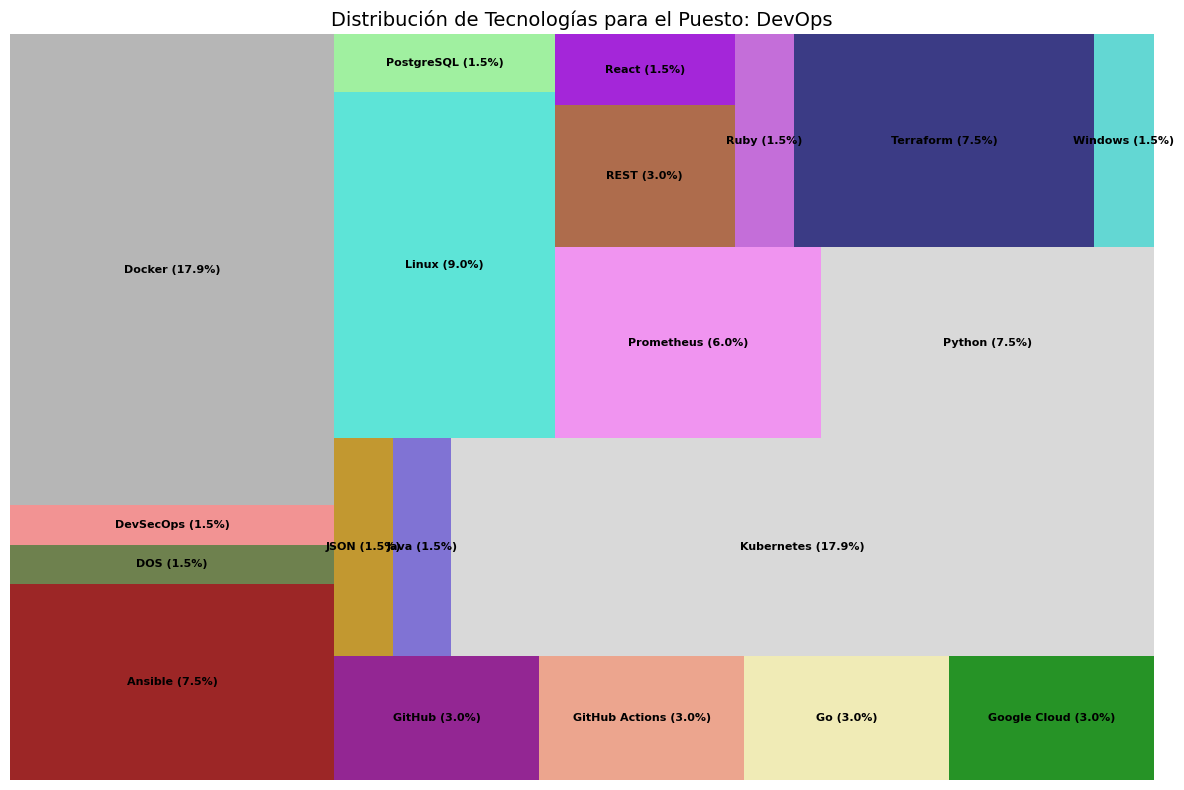

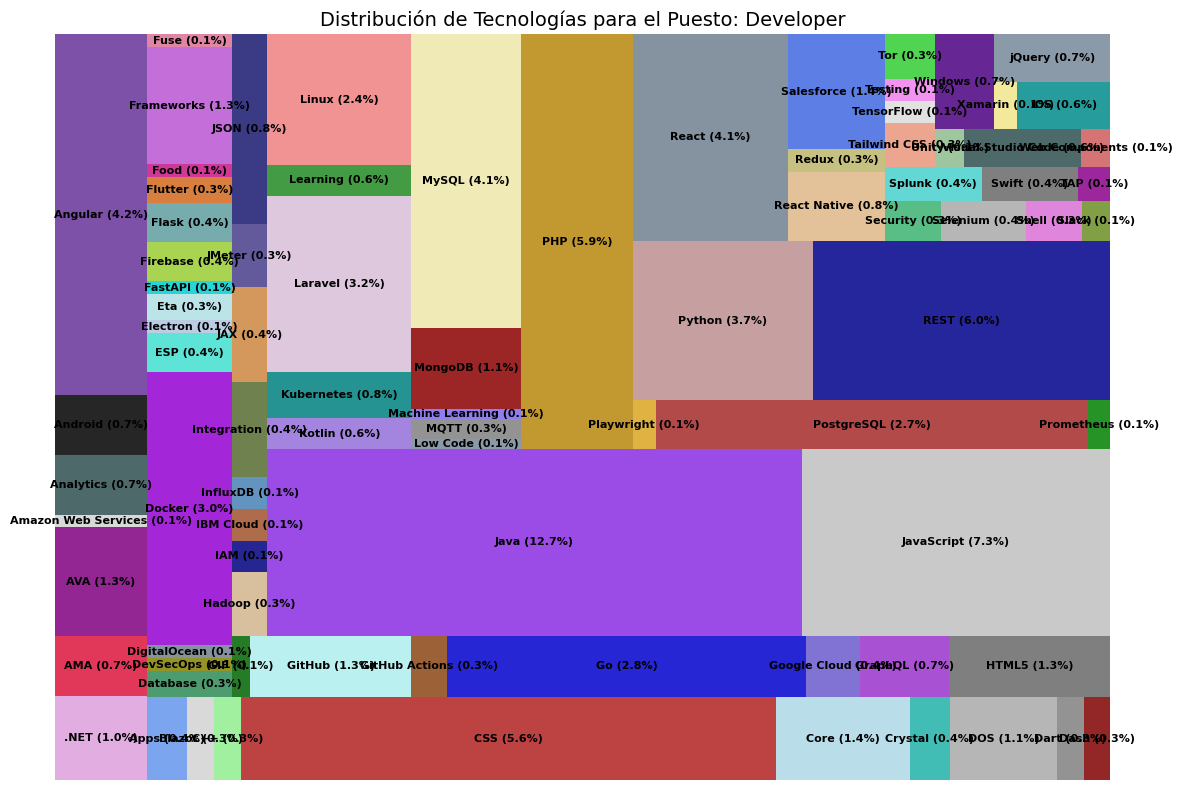

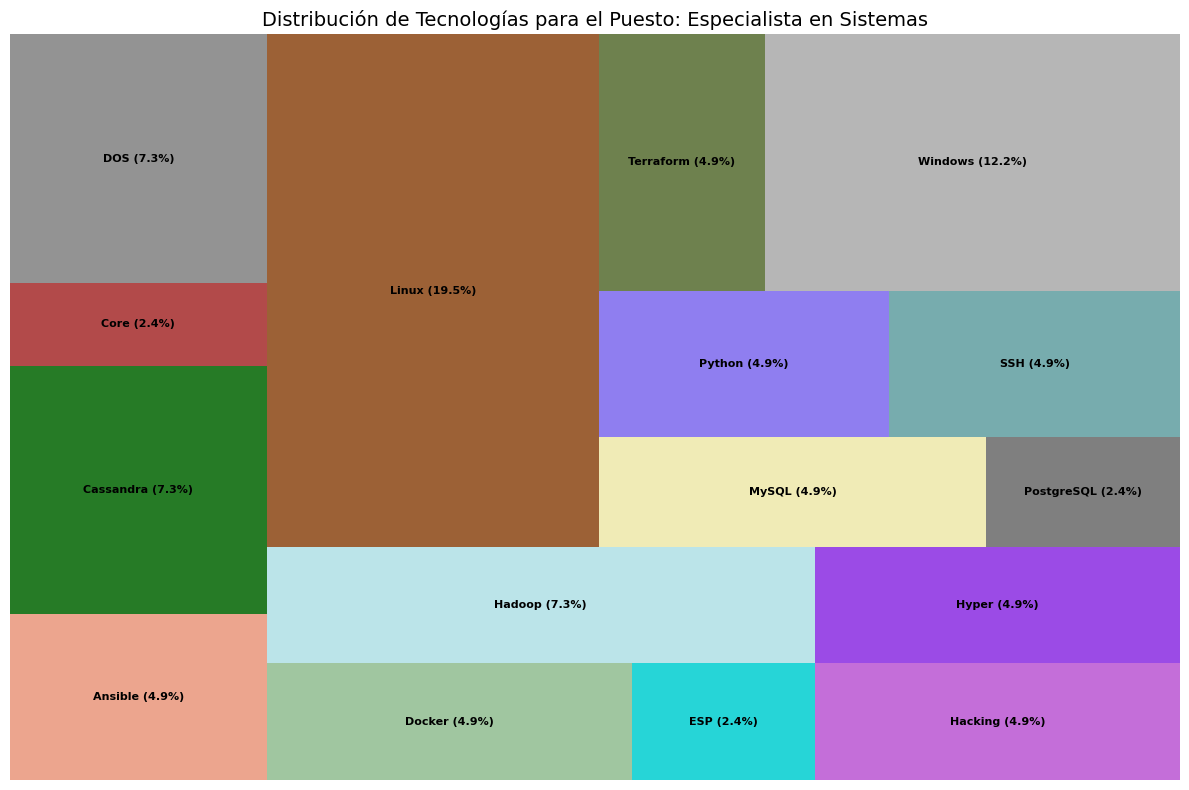

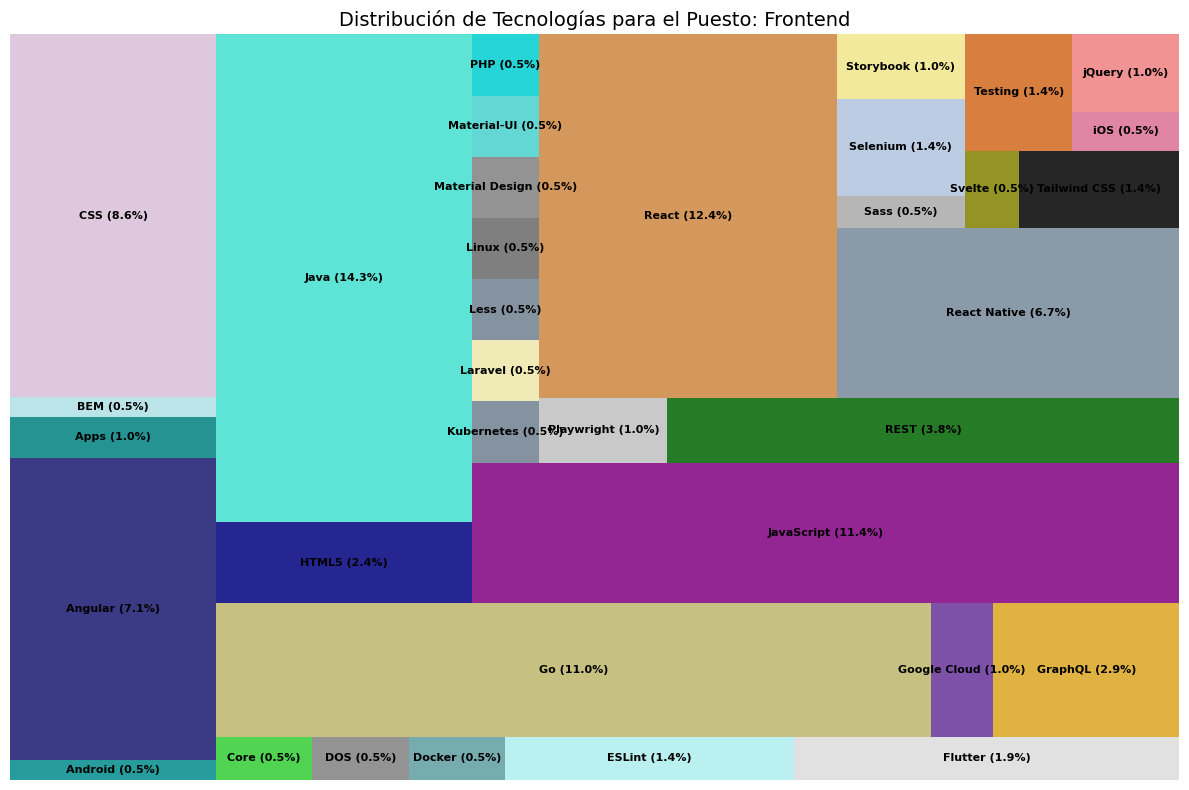

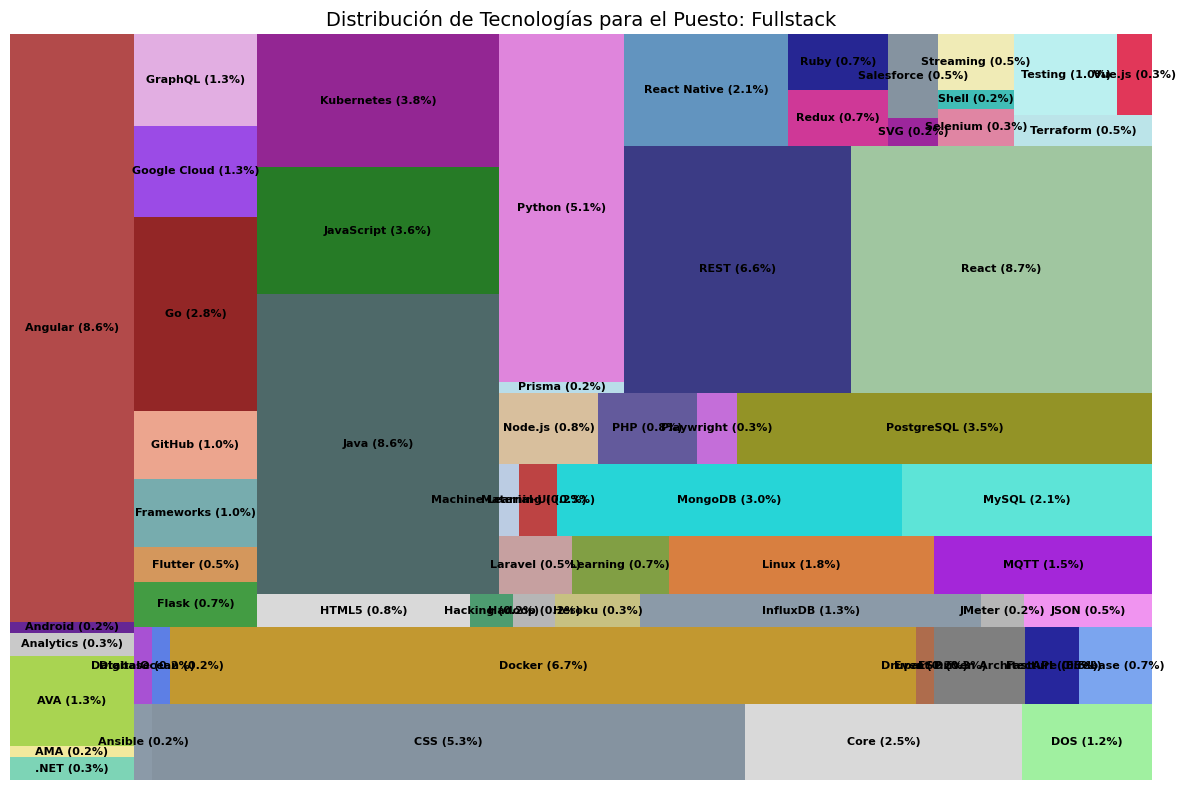

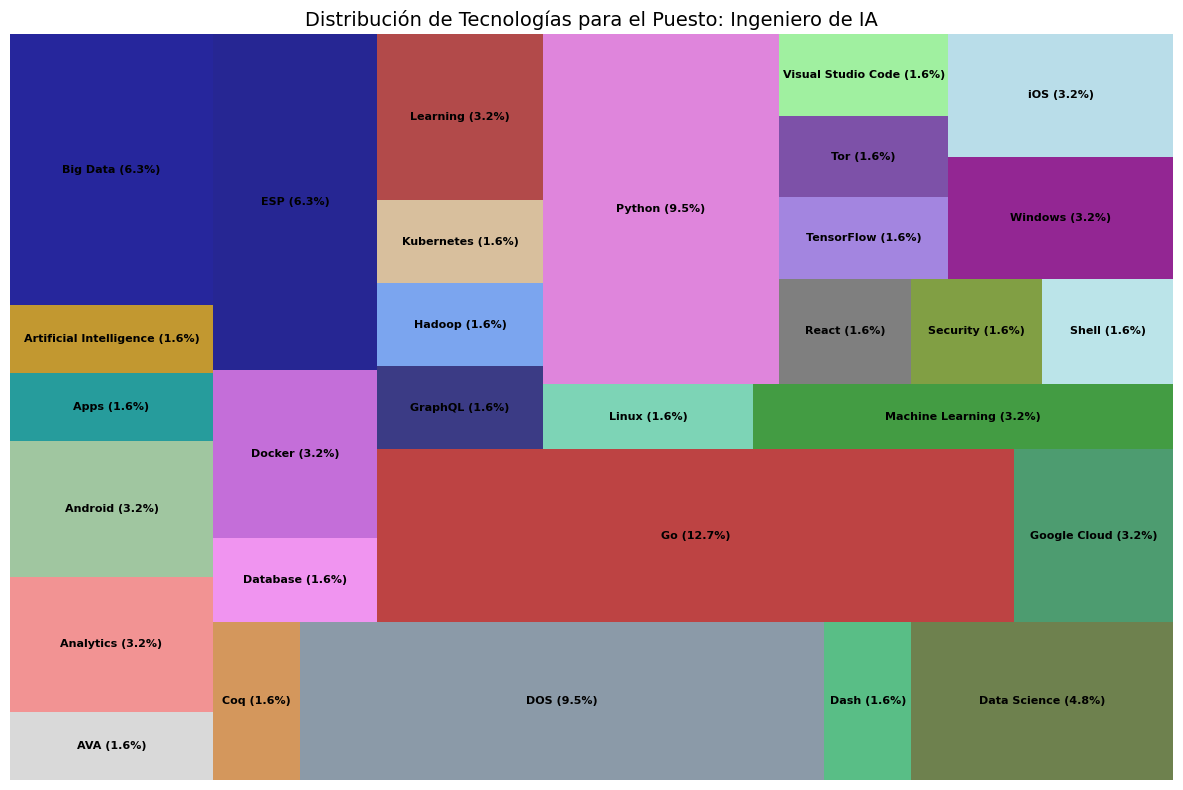

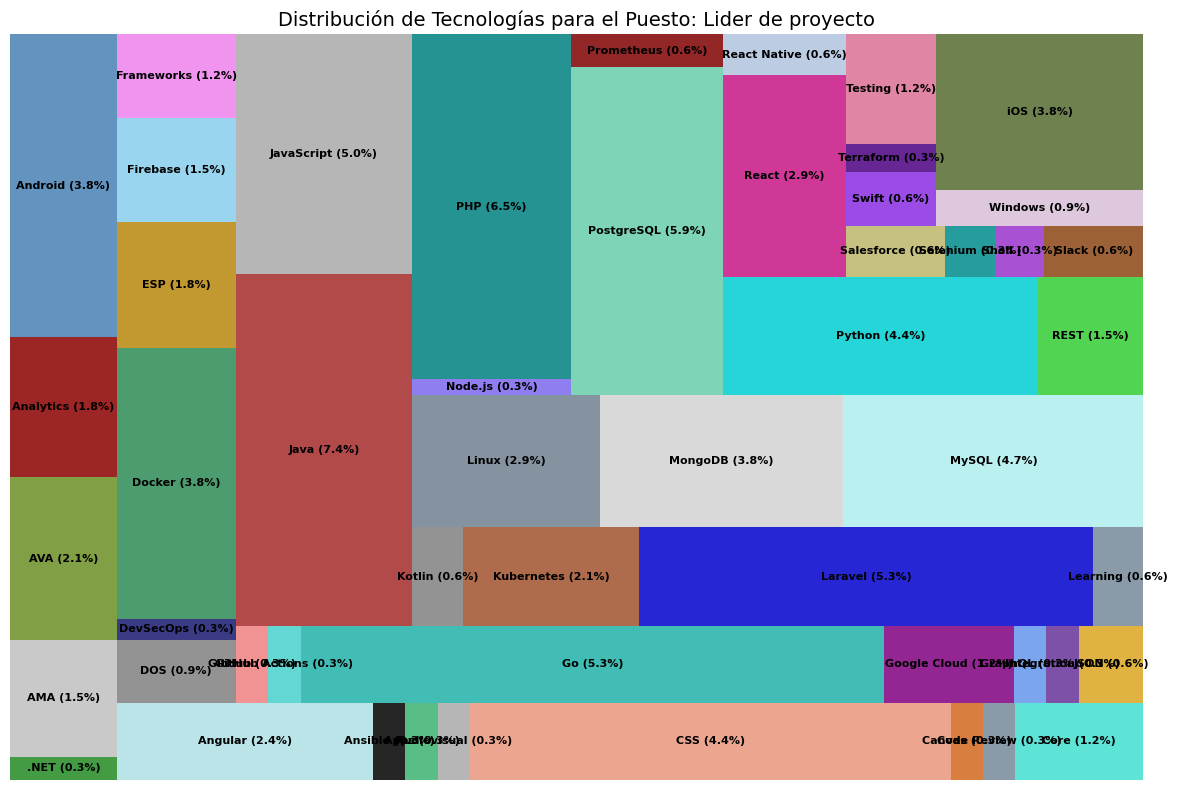

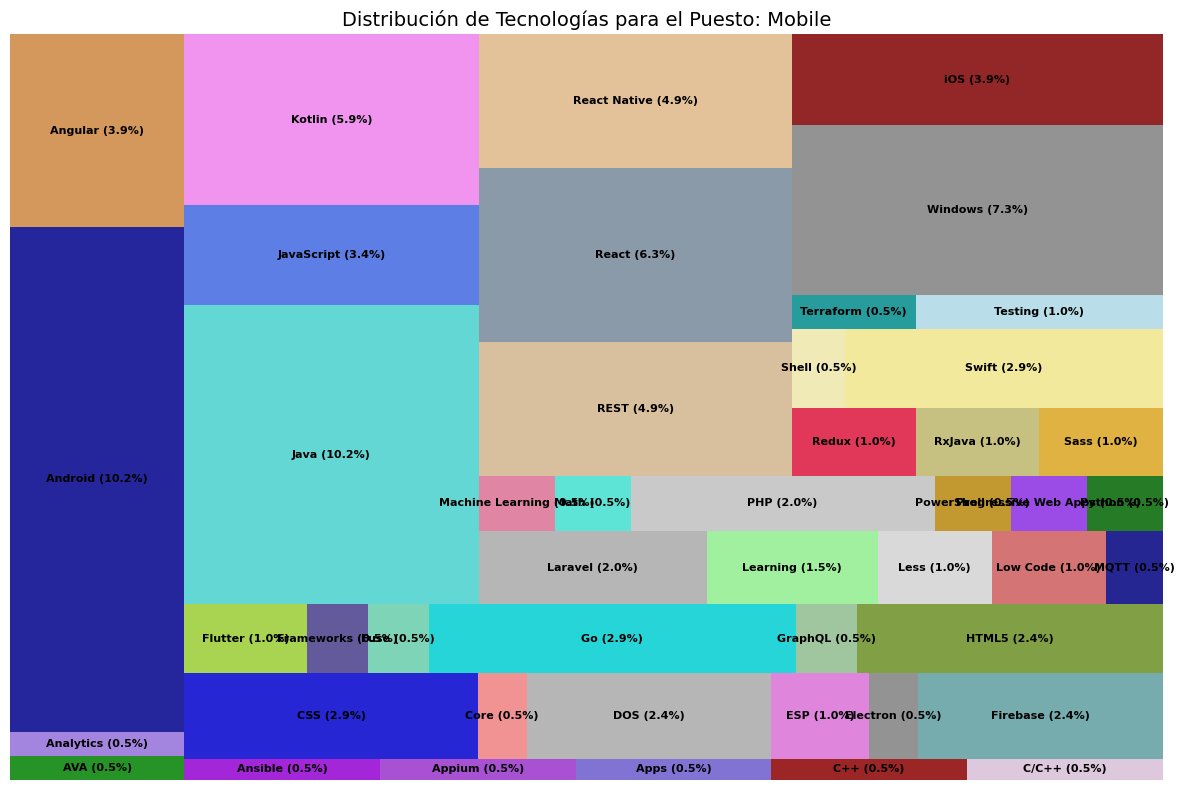

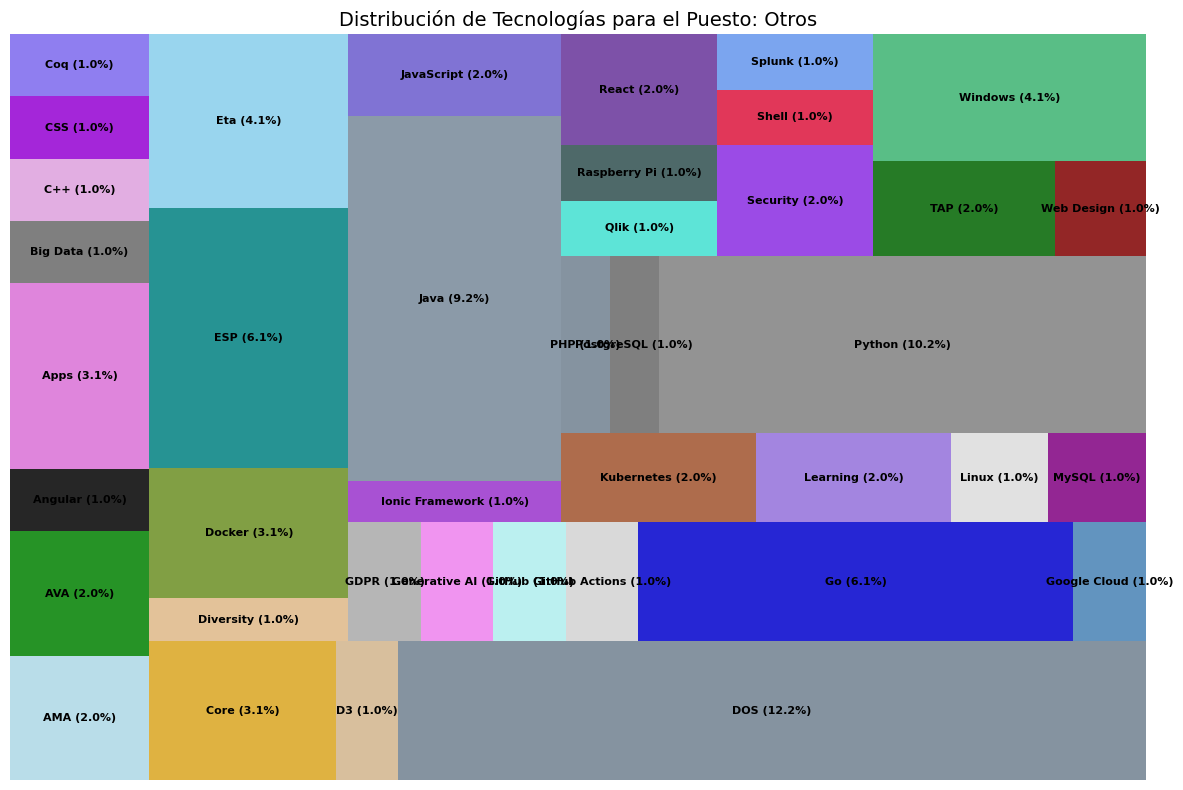

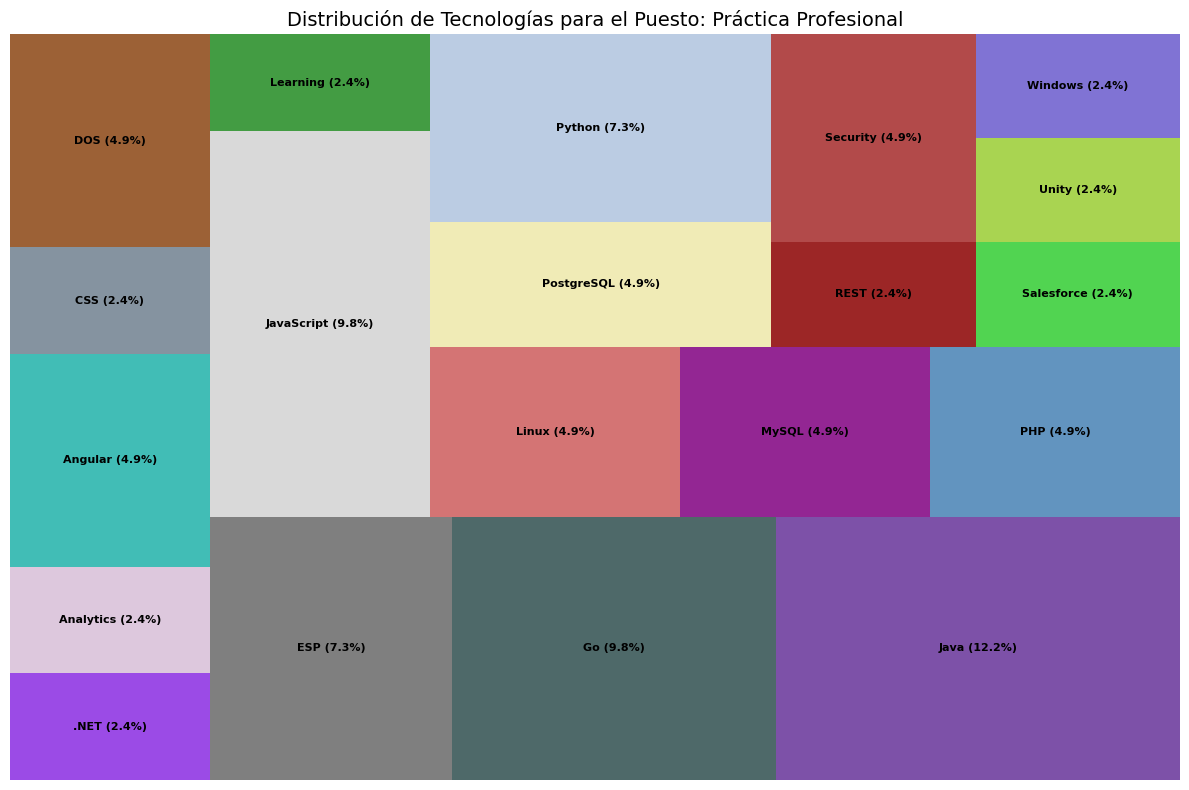

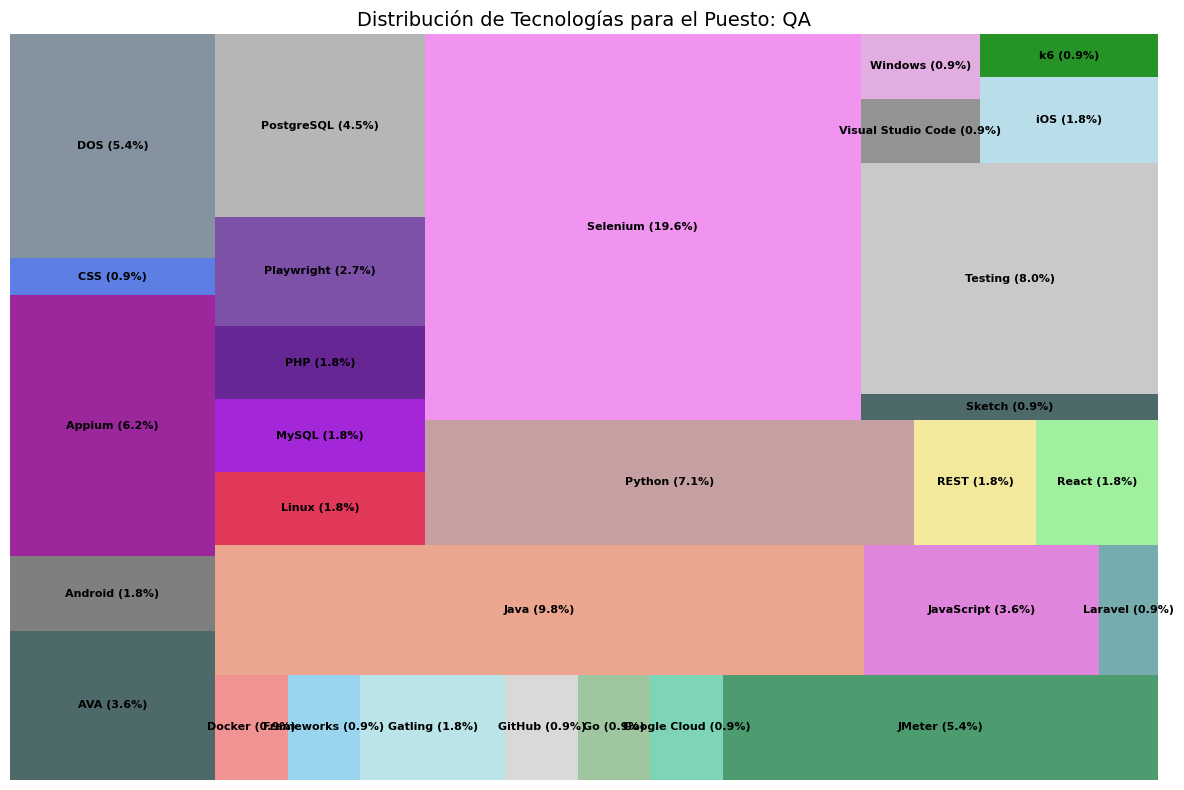

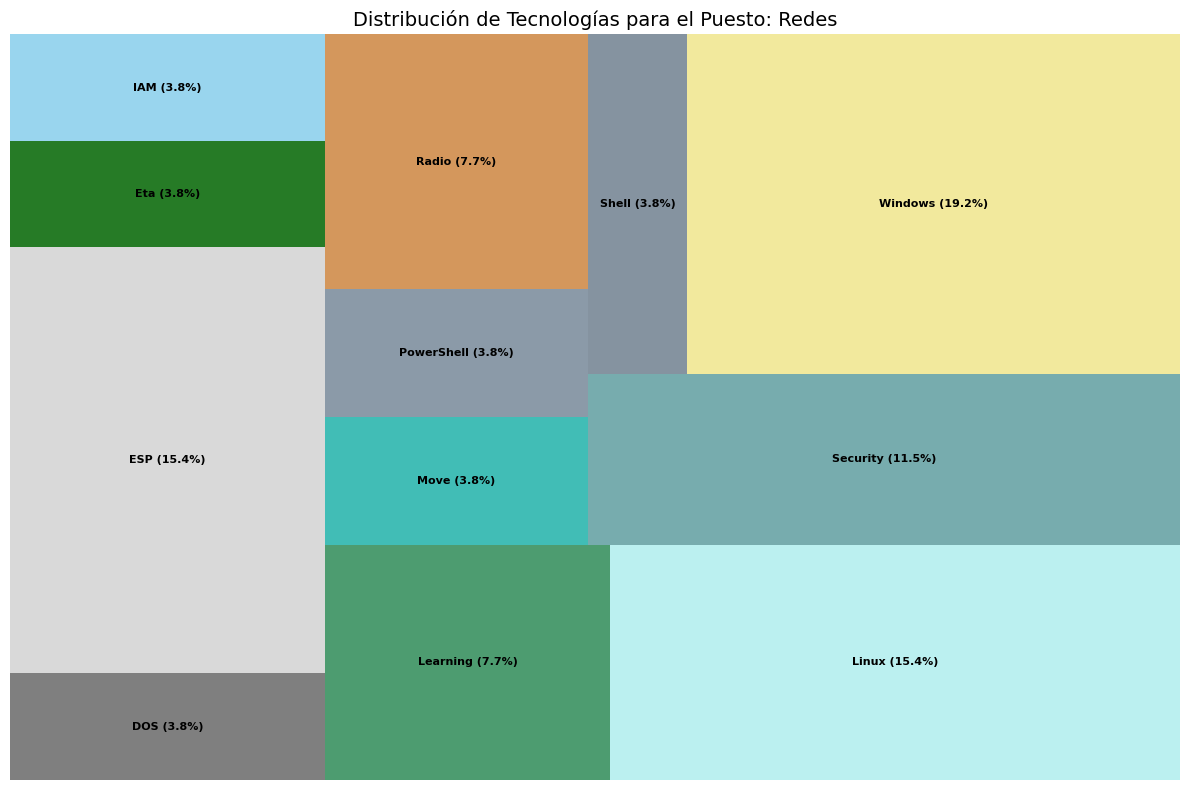

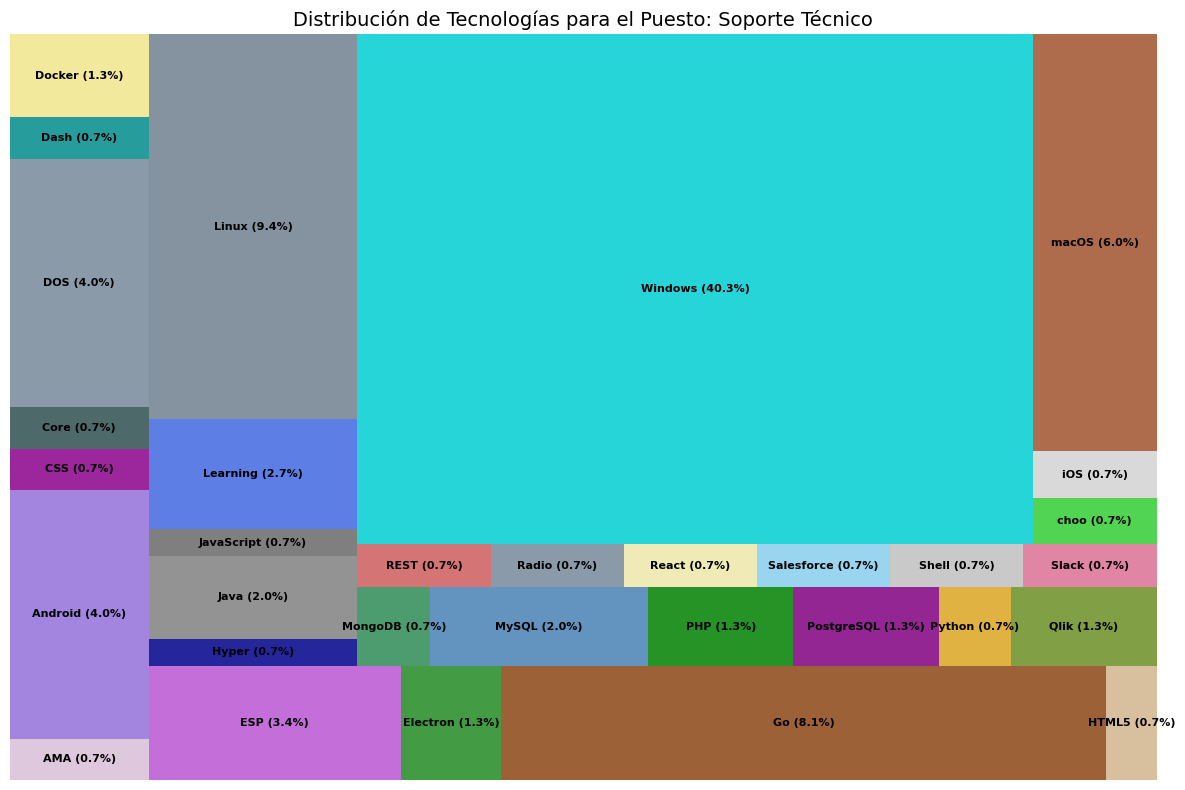

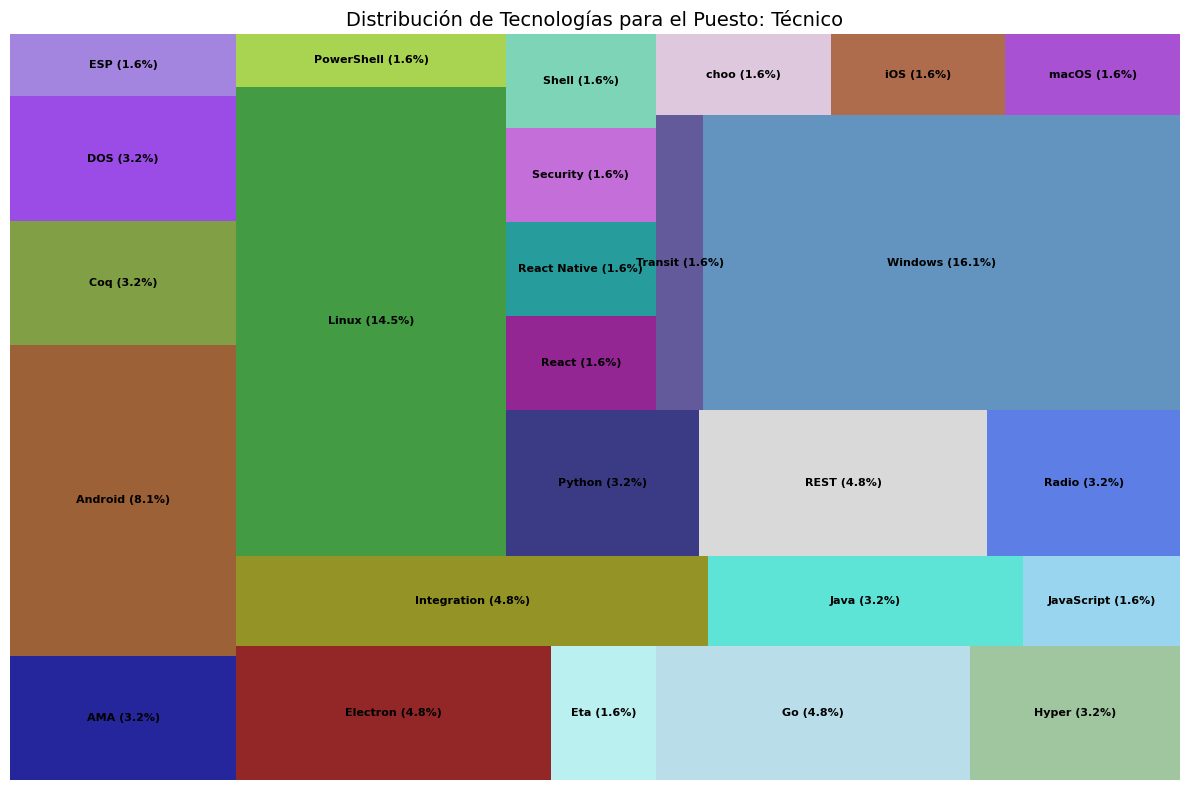

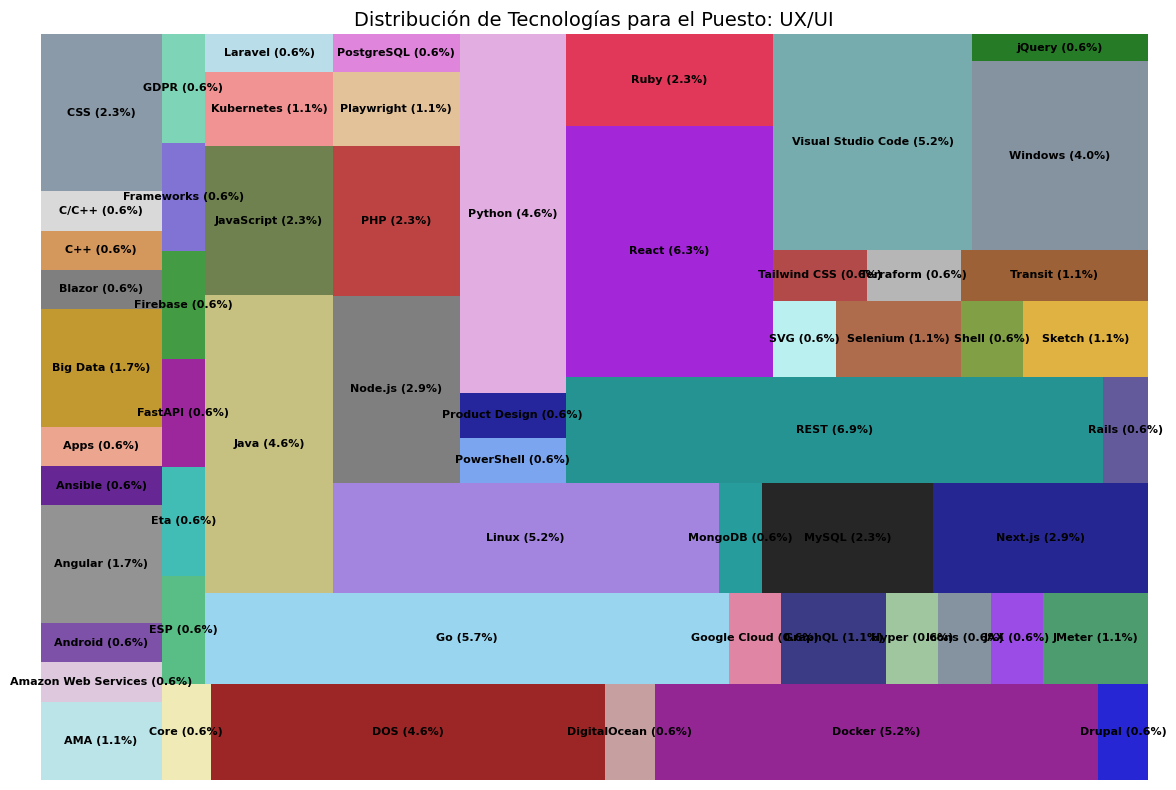

In [21]:
import re
import random
import matplotlib.colors as mcolors
import squarify


def extraer_items(cleaned_text):
    items = []
    # Separamos el texto por líneas
    for line in cleaned_text.splitlines():
        line = line.strip()
        # Consideramos sólo las líneas que inician con "- "
        if line.startswith('- '):
            # Quitamos el guión y el espacio inicial
            item = line[2:].strip()
            # Reemplazamos los enlaces Markdown [Texto](URL) por solo "Texto"
            item = re.sub(r'\[([^\]]+)\]\([^)]+\)', r'\1', item)
            # Si hay descripciones adicionales separadas por " - ", tomamos solo el primer segmento
            item = item.split(' - ')[0].strip()
            # Nos aseguramos de que sea una cadena de texto (plain text)
            items.append(str(item))
    return items

def clean_markdown(md_text):
    # 1. Elimina todas las etiquetas HTML
    cleaned = re.sub(r'<[^>]+>', '', md_text)
    return re.sub(r'## Contents.*?(?=\n## )', '', cleaned, flags=re.DOTALL)

def remove_contents_section(text):
    """
    Elimina la sección de "## Contents" junto con su contenido hasta el siguiente encabezado '##'.
    """
    # La bandera DOTALL permite que el . incluya saltos de línea
    return re.sub(r'## Contents.*?(?=\n## )', '', text, flags=re.DOTALL)

with open("tecs.md", "r", encoding="utf-8") as file:
    markdown_text = file.read()

def clasificar_tecnologias(texto):
    if not isinstance(texto, str):
        return texto
    tecs = []
    for tec in tecnologias:
        if tec in texto:
            if tec not in tecs:
                tecs.append(tec)
    return tecs



markdown_limpio = clean_markdown(markdown_text)

tecnologias = extraer_items(markdown_limpio)
print(f"Total de tecnologías encontradas: {len(tecnologias)}")


df["Tecnologias"]=df["Descripcion"].apply(clasificar_tecnologias)
df2["Tecnologias"]=df2["Descripción"].apply(clasificar_tecnologias)
df3["Tecnologias"]=df3["descripcion"].apply(clasificar_tecnologias)




def generar_puestos_tecnologias(lista_df):
    puestos_tecnologias = []
    for df_temp in lista_df:
        # Verificar si el DataFrame tiene la columna "Puesto".
        if 'Puesto' not in df_temp.columns:
            continue
        for index, row in df_temp.iterrows():
            puesto = row['Puesto']
            tecnologias_asociadas = row['Tecnologias']
            # Aseguramos que sean listas (por si hay valores que no lo sean)
            if isinstance(tecnologias_asociadas, list):
                for tecnologia in tecnologias_asociadas:
                    puestos_tecnologias.append({'Puesto': puesto, 'Tecnologia': tecnologia})
    # Convertir la lista a un DataFrame
    tabla = pd.DataFrame(puestos_tecnologias)
    # Agrupar por "Puesto" y "Tecnologia" para contar las ocurrencias
    tabla_agrupada = tabla.groupby(['Puesto', 'Tecnologia']).size().reset_index(name='Cantidad')
    return tabla_agrupada

# Se combinan los tres DataFrames en una lista y se genera la tabla
tabla_puestos_tecnologias = generar_puestos_tecnologias([df, df2, df3])

# Crear un gráfico de torta para cada puesto con las tecnologías asociadas
puestos_unicos = tabla_puestos_tecnologias['Puesto'].unique()

for puesto in puestos_unicos:
    tecnologias_puesto = tabla_puestos_tecnologias[tabla_puestos_tecnologias['Puesto'] == puesto]
    labels = tecnologias_puesto['Tecnologia'].values
    sizes = tecnologias_puesto['Cantidad'].values

    n_labels = len(labels)

    # Generar colores sin tonos muy claros
    base_colors = list(mcolors.CSS4_COLORS.values())
    base_colors = [c for c in base_colors if mcolors.rgb_to_hsv(mcolors.to_rgb(c))[2] < 0.95]
    selected_colors = random.sample(base_colors, n_labels)
    random.shuffle(selected_colors)

    # Agregar porcentaje al label
    total = sum(sizes)
    labels_with_pct = [f"{label} ({size / total * 100:.1f}%)" for label, size in zip(labels, sizes)]

    # Crear el treemap
    pltgr.figure(figsize=(12, 8))
    squarify.plot(
        sizes=sizes,
        label=labels_with_pct,
        color=selected_colors,
        alpha=0.85,
        text_kwargs={'fontsize': 8,'fontweight': 'bold', 'color': 'black'},
    )

    pltgr.axis('off')  # Quitar ejes
    pltgr.title(f'Distribución de Tecnologías para el Puesto: {puesto}', fontsize=14)
    pltgr.tight_layout()
    pltgr.show()

In [ ]:


region_dropdown = ipw.Dropdown(description="Región:", layout=ipw.Layout(width="300px"))
provincia_dropdown = ipw.Dropdown(description="Provincia:", layout=ipw.Layout(width="300px"))
comuna_dropdown = ipw.Dropdown(description="Comuna:", layout=ipw.Layout(width="300px"))

rango_dropdown = ipw.IntSlider(
    value=0,
    min=0,
    max=200000000,
    step=1,
    description='Salario:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

puesto_dropdown = ipw.Dropdown(
    options=["Ninguno", "Frontend", "Backend", "Data Analyst"],
    description='Puesto:',
    layout=ipw.Layout(width='250px')
)

# -------- KPIs --------
kpi_empleos = ipw.HTML(value="<h3 style='text-align:center;'>100<br><span style='font-size:14px'>Cantidad total de empleos</span></h3>")
kpi_salario = ipw.HTML(value="<h3 style='text-align:center;'>$1.200.000<br><span style='font-size:14px'>Salario Promedio</span></h3>")

kpi_box_1 = ipw.HBox([ipw.Label("🔢"), kpi_empleos])
kpi_box_2 = ipw.HBox([ipw.Label("💰"), kpi_salario])
kpi_section = ipw.HBox([kpi_box_1, kpi_box_2])

# -------- Imagen o gráfico placeholder --------
plot_output = ipw.Output()
with plot_output:
    grafico_ofertas_por_region_interactivo(plot_output=plot_output)



def actualizar_kpis():
    # Si hay una comuna seleccionada, filtrar por comuna
    comuna = comuna_dropdown.value
    if comuna:
        # Filtrar tabla_ciudades_total por la comuna seleccionada
        filtro = tabla_ciudades_total["Ciudad/Comuna"].str.lower() == comuna.lower()
        total = tabla_ciudades_total.loc[filtro, "Cantidad_Ofertas"].sum()  
        # filtrar promedio_salarios_total por la comuna seleccionada
        filtro_salario = promedio_salarios_total["Ciudad/Comuna"].str.lower() == comuna.lower() # type: ignore
        # Calcular el promedio de salario solo para la comuna seleccionada
        promedio = promedio_salarios_total.loc[filtro_salario, "Promedio_Salario"].sum() # type: ignore
    else:
        total = tabla_ciudades_total["Cantidad_Ofertas"].sum()
        promedio = promedio_salarios_total["Promedio_Salario"].mean()  # type: ignore

    kpi_empleos.value = f"<h3 style='text-align:center;'>{int(total)}<br><span style='font-size:14px'>Cantidad total de empleos</span></h3>"
    kpi_salario.value = f"<h3 style='text-align:center;'>${promedio:,.0f}<br><span style='font-size:14px'>Salario Promedio</span></h3>"
    # -------- Layout general por pestaña --------   
    return None


##
def actualizar_provincias(change):        
    region = change['new']
    provincias = chile[chile["Región"] == region]["Provincia"].unique()
    provincia_dropdown.options = sorted(provincias)
    
    # Resetear comunas
    comuna_dropdown.options = []

def actualizar_comunas(change):
    provincia = change['new']
    comunas = chile[chile["Provincia"] == provincia]["Comuna"].unique()
    comuna_dropdown.options = sorted(comunas)


def tab_1():
    filtros = ipw.VBox([region_dropdown, provincia_dropdown, comuna_dropdown, rango_dropdown])
    derecha = ipw.VBox([
            plot_output,
    ], layout=ipw.Layout(width='600px', min_width='400px', max_width='800px', align_items='flex-start'))
    layout = ipw.HBox([
        filtros,
        ipw.VBox([kpi_section, derecha], layout=ipw.Layout(margin='0 0 0 40px'))
    ])
    return layout

##
region_dropdown.options = sorted(chile["Región"].unique())
provincia_dropdown.options = []
comuna_dropdown.options = []
actualizar_kpis()  # Inicializar KPIs al cargar la pestaña

region_dropdown.observe(actualizar_provincias, names='value')
provincia_dropdown.observe(actualizar_comunas, names='value')
def on_comuna_change(change):
    comuna = change['new']
    actualizar_kpis()  # Actualizar KPIs al cambiar la comuna
    if comuna:
        with plot_output:
            plot_output.clear_output(wait=True)
            grafico_iteract_ofertas_por_ciudad(comuna, plot_output=plot_output)
    else:
        with plot_output:
            plot_output.clear_output(wait=True)
            grafico_ofertas_por_region_interactivo(plot_output=plot_output)
        

comuna_dropdown.observe(on_comuna_change, names='value')


# Otras pestañas vacías por ahora
tab_2 = ipw.HTML("<h3>Tecnologías (en desarrollo)</h3>")
tab_3 = ipw.HTML("<h3>Seguridad (en desarrollo)</h3>")

# -------- Tabs dashboard --------
tabs = ipw.Tab()
tabs.children = [tab_1(), tab_2, tab_3]
tabs.set_title(0, "Cantidad de empleos y salarios")
tabs.set_title(1, "Tecnologías")
tabs.set_title(2, "Seguridad")

display(tabs)
